In [1]:
# Standard libraries
import csv
import glob
import json
import math
import os
import random
import re
import subprocess
import sys
import time
from shutil import copy2

# Third-party libraries
import getpass
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml

# BioPython
from Bio import SeqIO
from Bio.PDB import PDBParser, PPBuilder
from Bio.PDB.vectors import calc_dihedral

# Excel writer
from openpyxl.workbook import Workbook

# Local utilities
### Path to this cloned GitHub repo:
SCRIPT_DIR = os.path.dirname("/path/to/this/file/PCBpipeline.ipynb") # edit this to the GitHub repo path. Throws an error by default.
assert os.path.exists(SCRIPT_DIR)
sys.path.append(SCRIPT_DIR + "/scripts/utils")
import utils

# Debugging
print(SCRIPT_DIR)
print(sys.path)

/rds/general/user/wh621/home/heme_binder_diffusion
['/rds/general/user/wh621/home/miniforge3/envs/pipeline/lib/python311.zip', '/rds/general/user/wh621/home/miniforge3/envs/pipeline/lib/python3.11', '/rds/general/user/wh621/home/miniforge3/envs/pipeline/lib/python3.11/lib-dynload', '', '/rds/general/user/wh621/home/miniforge3/envs/pipeline/lib/python3.11/site-packages', '/rds/general/user/wh621/home/heme_binder_diffusion/scripts/utils']


# De novo heme binding protein design pipeline using RFdiffusionAA
#### And other ligand binders too, I guess
Indrek Kalvet, PhD (Institute for Protein Design, University of Washington), ikalvet@uw.edu

As implemented in the publication "<i>Generalized Biomolecular Modeling and Design with RoseTTAFold All-Atom"

Link:

This notebook illustrates the design of heme-binding proteins, starting from minimal information (heme + substrate + CYS motif). It should work with minor modifications also for any other ligand.

The pipeline consists of 7 steps:<br>

    0) The protein backbones are generated with RFdiffusionAA
    1) Sequence is designed with proteinMPNN (without the ligand)
    2) Structures are predicted with AlphaFold2
    3) Ligand binding site is designed with LigandMPNN/FastRelax, or Rosetta FastDesign
    4) Sequences surrounding the ligand pocket are diversified with LigandMPNN
    5) Final designed sequences are predicted with AlphaFold2
    6) Alphafold2-predicted models are relaxed with the ligand and analyzed


## Paths of important Python scripts and programs

#### RFdiffusionAA:
Download RFdiffusionAA from here: https://github.com/baker-laboratory/rf_diffusion_all_atom

#### RFjoint inpainting (proteininpainting)
(Optional) Download RFjoint Inpainting here: https://github.com/RosettaCommons/RFDesign

Inpainting is used to further resample/diversify diffusion outputs, and it may also increase AF2 success rates.
<br>

#### AlphaFold2 and LigandMPNN
Other dependencies (ligandMPNN and AlphaFold2) are downloaded as submodules with this GitHub repository.

<br>
<br>
<i>After these evironments are set up and repositories are downloaded please provide paths to the inference scripts in the cell below:</i>

<br>
<br>

#### Python or Apptainer image
Please define in the cell below any Python executables or Apptainer image paths that are able to run the different scripts.<br>

This pipeline is tested to run based on two different Conda environments: `diffusion` and `mlfold`.<br>
Both of these can be set up based on the yml files provided by this repository.<br>
`mlfold` is used for AlphaFold2, and `diffusion` is used for everything else.

<br>

Alternatively, if your system is using Apptainers, you can set them up based on the same yml files, or do it separately. For RFdiffusionAA you can download this Apptainer image:
http://files.ipd.uw.edu/pub/RF-All-Atom/containers/rf_se3_diffusion.sif

If you are setting the environments or containers up without the provided YML files, then the minimum requirements for the different types are:<br>
`af2` Python needs to include jax=0.4.25 and jaxlib=0.4.23<br>
`proteinMPNN` Python needs to include pytorch and prody<br>
`general` Python needs to include pytorch, pyrosetta, prody<br>



In [2]:
diffusion_script = "/your/own/path/run_inference.py"  # edit this
# inpaint_script = "PATH/TO/RFDesign/inpainting/inpaint.py"  # edit this if needed
proteinMPNN_script = f"{SCRIPT_DIR}/lib/LigandMPNN/run.py"  # from submodule
AF2_script = f"{SCRIPT_DIR}/scripts/af2/af2.py"  # from submodule

print({SCRIPT_DIR})

### Python and/or Apptainer executables needed for running the jobs
### Please provide paths to executables that are able to run the different tasks.
### They can all be the same if you have an environment with all of the ncessary Python modules in one

# If your added Apptainer does not execute scripts directly,
# try adding 'apptainer run' or 'apptainer run --nv' (for GPU) in front of the command

CONDAPATH = "/rds/general/user/wh621/home/miniforge3"   # edit this depending on where your Conda environments live
PYTHON = {"diffusion": f"{CONDAPATH}/envs/diffusion/bin/python",
          "af2": f"{CONDAPATH}/envs/mlfold/bin/python",
          "proteinMPNN": f"{CONDAPATH}/envs/diffusion/bin/python",
          "general": f"{CONDAPATH}/envs/diffusion/bin/python"}

{'/rds/general/user/wh621/home/heme_binder_diffusion'}


## Project description and paths

In [3]:
username = getpass.getuser()  # your username on the running system
print(username)

PROJECT = "example_Heme_diffusion"

### Path where the jobs will be run and outputs dumped
WDIR = f"{SCRIPT_DIR}/output"

if not os.path.exists(WDIR):
    os.makedirs(WDIR, exist_ok=True)

print(f"Working directory: {WDIR}")

USE_GPU_for_AF2 = True

wh621
Working directory: /rds/general/user/wh621/home/heme_binder_diffusion/output


In [4]:
# Ligand information
params = [f"{SCRIPT_DIR}/theozyme/PCB/PCB.params"]  # Rosetta params file(s)
LIGAND = "PCB"

## 0: Setting up diffusion run

In [11]:
# Using example PDB file with ligand HBA and protein 7o2g backbone.
## Note: the repository also contains additional HBA conformers with 7o2g and P450 motifs
## in the same directory as a ZIP file.

# Don't forget that the wildcard has been replaced with a PET

diffusion_inputs = glob.glob(f"{SCRIPT_DIR}/input/*.pdb")
print(f"Found {len(diffusion_inputs)} PDB files")
print(diffusion_inputs)

Found 4 PDB files
['/rds/general/user/wh621/home/heme_binder_diffusion/input/pcb1438.pdb', '/rds/general/user/wh621/home/heme_binder_diffusion/input/pcb1829.pdb', '/rds/general/user/wh621/home/heme_binder_diffusion/input/pcb1968.pdb', '/rds/general/user/wh621/home/heme_binder_diffusion/input/pcb215.pdb']


In [6]:
## Setting up general settings for diffusion
DIFFUSION_DIR = f"{WDIR}/0_diffusion"

if not os.path.exists(DIFFUSION_DIR):
    os.makedirs(DIFFUSION_DIR, exist_ok=False)

os.chdir(DIFFUSION_DIR)

N_designs = 50
T_steps = 200

## Edit this config based on motif residues, etc...
## Don't forget Length: 150-210 was removed. This is because we don't need to yoink a cysteine residue out of the input PDB.
config = f"""
defaults:
  - aa

diffuser:
  T: {T_steps}

inference:
  num_designs: {N_designs}
  model_runner: NRBStyleSelfCond
  ligand: '{LIGAND}'

model:
  freeze_track_motif: True

contigmap:
  contigs: ["80-120"]
  inpaint_str: null

potentials:
  guiding_potentials: ["type:ligand_ncontacts,weight:1"] 
  guide_scale: 2
  guide_decay: cubic
"""

estimated_time = 3.5 * T_steps * N_designs  # assuming 3.5 seconds per timestep on A4000 GPU

print(f"Estimated time to produce {N_designs} designs = {estimated_time/60:.0f} minutes")
with open("config.yaml", "w") as file:
    file.write(config)
print(f"Wrote config file to {os.path.realpath('config.yaml')}")

Estimated time to produce 50 designs = 583 minutes
Wrote config file to /rds/general/user/wh621/home/heme_binder_diffusion/output/0_diffusion/config.yaml


In [7]:
## Setting up diffusion commands based on the input PDB file(s)
## Diffusion jobs are run in separate directories for each input PDB

jobs = 50 # Defines the number of separate jobs to run. Total diffusion traj = jobs * N_designs

commands_diffusion = []
cmds_filename = "commands_diffusion"
diffusion_rundirs = []

'''
This function here is not gonna work when jobs number > 1; its overwriting, not batching. Use the function below.
with open(cmds_filename, "w") as file:
    for p in diffusion_inputs:
        pdbname = os.path.basename(p).replace(".pdb", "")
        os.makedirs(pdbname, exist_ok=True)
        cmd = f"cd {pdbname} ; {PYTHON['diffusion']} {diffusion_script} --config-dir=../ "\
              f"--config-name=config.yaml inference.input_pdb={p} "\
              f"inference.output_prefix='./out/{pdbname}_dif' > output.log ; cd ..\n"
        commands_diffusion.append(cmd)
        diffusion_rundirs.append(pdbname)
        file.write(cmd)
'''

with open(cmds_filename, "w") as file:
    for job_id in range(jobs):
        for p in diffusion_inputs:
            pbasename = os.path.basename(p).replace(".pdb", "")
            rundir = f"{pbasename}_job{job_id}"
            os.makedirs(rundir, exist_ok=True)
            cmd = (
                f"cd {rundir} ; "
                f"{PYTHON['diffusion']} {diffusion_script} --config-dir=../ "
                f"--config-name=config.yaml inference.input_pdb={p} "
                f"inference.output_prefix='./out/{pbasename}_job{job_id}_dif' > output.log ; cd ..\n"
            )
            commands_diffusion.append(cmd)
            diffusion_rundirs.append(rundir)
            file.write(cmd)

print(f"An example diffusion command that was generated:\n   {cmd}")


## Creating a Slurm submit script
## adjust time depending on number of designs and available hardware
submit_script = "submit_diffusion.sh"
utils.create_slurm_submit_script(filename=submit_script, name="diffusion_example", gpu=True, gres="gpu:a2000:1",
                                 mem="4g", N_cores=1, time="1:00", email=EMAIL, group=10,
                                 array=len(commands_diffusion), array_commandfile=cmds_filename)

print(f"Writing diffusion submission script to {submit_script}")
print(f"{len(commands_diffusion)} diffusion jobs to run")

#if not os.path.exists(DIFFUSION_DIR+"/.done"):
#    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#    (output, err) = p.communicate()

An example diffusion command that was generated:
   cd pcb215_job49 ; /rds/general/user/wh621/home/miniforge3/envs/diffusion/bin/python /rds/general/user/wh621/home/rf_diffusion_all_atom/run_inference.py --config-dir=../ --config-name=config.yaml inference.input_pdb=/rds/general/user/wh621/home/heme_binder_diffusion/input/pcb215.pdb inference.output_prefix='./out/pcb215_job49_dif' > output.log ; cd ..

Writing diffusion submission script to submit_diffusion.sh
200 diffusion jobs to run


In [12]:
## If you're done with diffusion and happy with the outputs then mark it as done
DIFFUSION_DIR = f"{WDIR}/0_diffusion"

os.chdir(DIFFUSION_DIR)

if not os.path.exists(DIFFUSION_DIR+"/.done"):
    with open(f"{DIFFUSION_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

### Analyzing diffusion outputs
The purpose of this step is to identify diffused backbones that meet certain quality criteria. These scaffolds should be relatively globular (measured by radius of gyration (rog), and longest helix). They should not have clashes between the ligand and the backbone, the ligand should not be too exposed (measured by relative SASA). The termini should not be too close to the ligand (term_mindist), and the backbone should not be too loopy. In the example below we are also looking for backbones that leave some part of the ligand more exposed.

In [9]:
### Analyzing diffusion outputs for clashes, ligand burial and scaffold quality
## If it's running too slowly consider increasing --nproc
##Remember: run the script 'submit_diffusion_analysis.sh' first to generate 'diffusion_analysis.sc'. 
##Before submitting 'submit_diffusion_analysis.sh':
  ## add line 'export LD_LIBRARY_PATH=$CONDA_PREFIX/lib:$LD_LIBRARY_PATH' after conda activate to fix the LIBRARY_PATH, 
  ## otherwise DAlphaBall cannot find libgfortran.so.5.'
analysis_script = f"{SCRIPT_DIR}/scripts/diffusion_analysis/process_diffusion_outputs.py"

diffusion_outputs = []
for d in diffusion_rundirs:
    diffusion_outputs += glob.glob(f"{d}/out/*.pdb")

# By default I don't use the --analyze flag. As a result the backbones are filtered as the script runs.
# You can set --analyze to True to calculate all scores for all backbones.
# This will slow the analysis down, but you can then filter the backbones separately afterwards.
dif_analysis_cmd_dict = {"--pdb": " ".join(diffusion_outputs),
                        "--ref": f"{SCRIPT_DIR}/input/*.pdb",
                        "--params": " ".join(params),
                        "--term_limit": "15.0",
                        "--SASA_limit": "0.3",  # Highest allowed relative SASA of ligand
                        "--loop_limit": "0.4",  # Fraction of backbone that can be loopy
#                        "--ref_catres": "A15",  # Position of CYS in diffusion input
                        "--rethread": True,
                        "--fix": True,
#                        "--exclude_clash_atoms": "O1 O2 O3 O4 C5 C10",  # Ligand atoms excluded from clashchecking because they are flexible
#                        "--ligand_exposed_atoms": "C45 C46 C47",  # Ligand atoms that need to be more exposed
#                        "--exposed_atom_SASA": "10.0",  # minimum absolute SASA for exposed ligand atoms
                        "--longest_helix": "30",
                        "--rog": "30.0",
                        "--partial": None,
                        "--outdir": None,
                        "--traj": "5/30",  # Also random 5 models are taken from the last 30 steps of the diffusion trajectory
                        "--trb": None,
                        "--analyze": False,
                        "--nproc": "4"}

analysis_command = f"{PYTHON['general']} {analysis_script}"
for k, val in dif_analysis_cmd_dict.items():
    if val is not None:
        if isinstance(val, list):
            analysis_command += f" {k}"
            analysis_command += " " + " ".join(val)
        elif isinstance(val, bool):
            if val == True:
                analysis_command += f" {k}"
        else:
            analysis_command += f" {k} {val}"
        print(k, val)

if len(diffusion_outputs) < 100:
    print(analysis_command)
else:
    print(f"There are {len(diffusion_outputs)} pdb files awaiting processing.")
    print(f"The analysis command has been constructed successfully.")
    print("First few pdb files to be processed:", diffusion_outputs[:5])

if len(diffusion_outputs) < 100:
    print("Analyzing locally")
    p = subprocess.Popen(analysis_command, shell=True)
    (output, err) = p.communicate()
else:
    print("Too many structures to analyze.")
    print("Running the analysis as a SLURM job.")
    submit_script = "submit_diffusion_analysis.sh"
    utils.create_slurm_submit_script(filename=submit_script, name="diffusion_analysis",
                                     mem="32g", N_cores=dif_analysis_cmd_dict["--nproc"], time="24:00:00", email=EMAIL,
                                     command=analysis_command, outfile_name="output_analysis")

diffused_backbones_good = glob.glob(f"{DIFFUSION_DIR}/filtered_structures/*.pdb")
print(' Warning!!! Have you added `  export LD_LIBRARY_PATH=$CONDA_PREFIX/lib:$LD_LIBRARY_PATH   ` after conda activate diffusion?') ## Always remember to do this.
print('If you see error below this line, ust submit `submit_diffusion_analysis.sh` first.')
dif_analysis_df = pd.read_csv(f"{DIFFUSION_DIR}/diffusion_analysis.sc", header=0, sep="\s+")

--pdb pcb1438_job0/out/pcb1438_job0_dif_34.pdb pcb1438_job0/out/pcb1438_job0_dif_43.pdb pcb1438_job0/out/pcb1438_job0_dif_8.pdb pcb1438_job0/out/pcb1438_job0_dif_2.pdb pcb1438_job0/out/pcb1438_job0_dif_17.pdb pcb1438_job0/out/pcb1438_job0_dif_37.pdb pcb1438_job0/out/pcb1438_job0_dif_15.pdb pcb1438_job0/out/pcb1438_job0_dif_31.pdb pcb1438_job0/out/pcb1438_job0_dif_13.pdb pcb1438_job0/out/pcb1438_job0_dif_46.pdb pcb1438_job0/out/pcb1438_job0_dif_35.pdb pcb1438_job0/out/pcb1438_job0_dif_26.pdb pcb1438_job0/out/pcb1438_job0_dif_14.pdb pcb1438_job0/out/pcb1438_job0_dif_48.pdb pcb1438_job0/out/pcb1438_job0_dif_38.pdb pcb1438_job0/out/pcb1438_job0_dif_20.pdb pcb1438_job0/out/pcb1438_job0_dif_36.pdb pcb1438_job0/out/pcb1438_job0_dif_19.pdb pcb1438_job0/out/pcb1438_job0_dif_32.pdb pcb1438_job0/out/pcb1438_job0_dif_30.pdb pcb1438_job0/out/pcb1438_job0_dif_21.pdb pcb1438_job0/out/pcb1438_job0_dif_47.pdb pcb1438_job0/out/pcb1438_job0_dif_22.pdb pcb1438_job0/out/pcb1438_job0_dif_40.pdb pcb1438_job0

chainbreak
loop_frac
longest_helix
loop_at_motif
rog
rCA_nonadj
lig_dist
term_mindist
SASA
SASA_rel


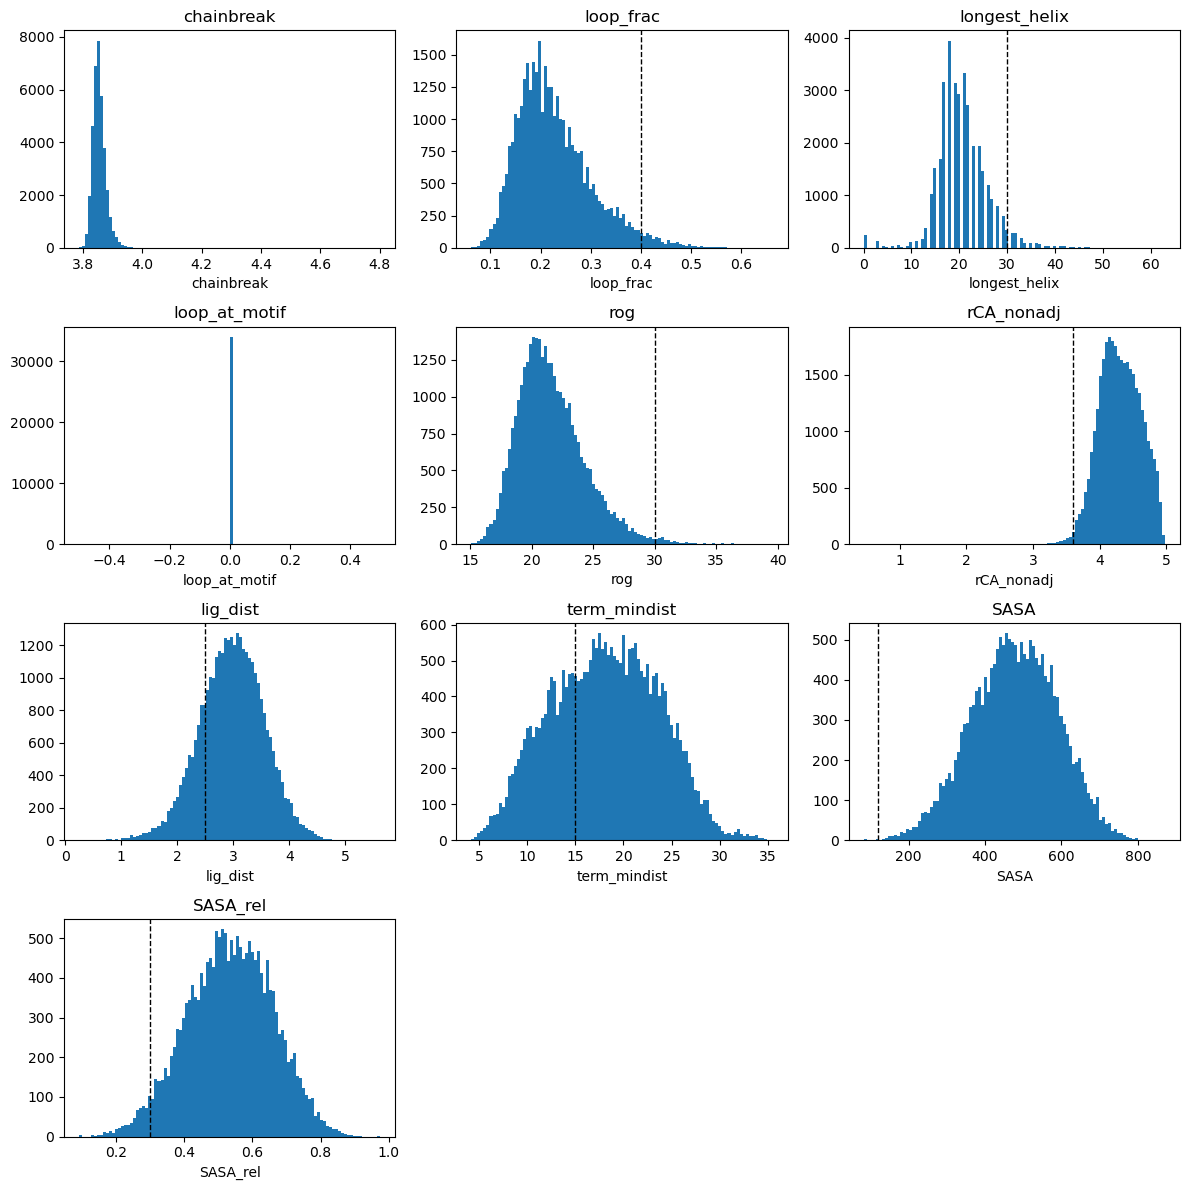

Number of Backbone files left= 607


In [12]:
## Visualizing the distributions of diffusion analysis metrics
## Plotting design scores
plt.figure(figsize=(12, 12))
for i,k in enumerate(dif_analysis_df.keys()):
    if k in ["description"]:
        continue
    plt.subplot(4, 3, i+1)
    plt.hist(dif_analysis_df[k], bins=100)
    plt.title(k)
    plt.xlabel(k)
    print(dif_analysis_df[k].name) # Technically script also checks if any CAs are >4.5 a away (chainbreak)

    if dif_analysis_df[k].name == "loop_frac":
        plt.axvline(0.4, color='k', linestyle='dashed', linewidth=1)
    elif dif_analysis_df[k].name == "longest_helix":
        plt.axvline(30, color='k', linestyle='dashed', linewidth=1)
    elif dif_analysis_df[k].name == "rog":
        plt.axvline(30, color='k', linestyle='dashed', linewidth=1)
    elif dif_analysis_df[k].name == "rCA_nonadj":
        plt.axvline(3.6, color='k', linestyle='dashed', linewidth=1) #  This number was grabbed from the source code.
    elif dif_analysis_df[k].name == "rog":
        plt.axvline(30, color='k', linestyle='dashed', linewidth=1)
    elif dif_analysis_df[k].name == "lig_dist":
        plt.axvline(2.5, color='k', linestyle='dashed', linewidth=1) # This number was grabbed from the source code.
    elif dif_analysis_df[k].name == "term_mindist":
        plt.axvline(15, color='k', linestyle='dashed', linewidth=1)   
    elif dif_analysis_df[k].name == "SASA":
        plt.axvline(120, color='k', linestyle='dashed', linewidth=1)    
    elif dif_analysis_df[k].name == "SASA_rel":
        plt.axvline(0.3, color='k', linestyle='dashed', linewidth=1)
#    print(dif_analysis_cmd_dict["--term_limit"])
plt.tight_layout()
plt.show()
backbones_left = glob.glob(f"{DIFFUSION_DIR}/filtered_structures/*.pdb")
count = len(backbones_left)
print(f"Number of Backbone files left= {count}")
assert len(backbones_left) > 0, "No good backbones found!"

It is highly advised that you manually inspect the filtered diffusion outputs before continuing with the pipeline.
While the filters attempt to pick out the most offending designs then nothing beats your own intuition and judgement.

If you would like to perform RFjoint Inpainting on the diffusion outputs, please go to the [inpainting section](#inpainting)

## 1: Running ProteinMPNN on diffused backbones

We are first trying to just design a sequence on the backbone, without considering the ligand.
The goal is to first find backbones that fold well.

In [11]:
diffused_backbones_good = glob.glob(f"{DIFFUSION_DIR}/filtered_structures/*.pdb")
assert len(diffused_backbones_good) > 0, "No good backbones found!"

os.chdir(WDIR)

MPNN_DIR = f"{WDIR}/1_proteinmpnn_new"

os.makedirs(MPNN_DIR, exist_ok=True)
os.chdir(MPNN_DIR)

####### I have commented out this entire section. It's used to find the residue numbers
# of cysteines in the heme binders so they don't get MPNNed out of existence.
# Because we're making a binder with no fixed residues, this whole section is unnecessary.
# Later references to the fixed_residues file have also been removed.

### Parsing diffusion output TRB files to extract fixed motif residues
## These residues will not be redesigned with proteinMPNN
#mask_json_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/make_maskdict_from_trb.py --out masked_pos.jsonl --trb"
#for d in diffused_backbones_good:
#    mask_json_cmd += " " + d.replace(".pdb", ".trb")
#p = subprocess.Popen(mask_json_cmd, shell=True)
#(output, err) = p.communicate()

#assert os.path.exists("masked_pos.jsonl"), "Failed to create masked positions JSONL file"


### Setting up proteinMPNN run commands
## We're doing design with 3 temperatures, and 5 sequences each.
## This usually gives decent success with designable backbones.
## For more complicated cases consider doing >100 sequences.

MPNN_temperatures = [0.1, 0.2, 0.3]
MPNN_outputs_per_temperature = 100
MPNN_omit_AAs = "CM"

commands_mpnn = []
cmds_filename_mpnn = "commands_mpnn"
with open(cmds_filename_mpnn, "w") as file:
    for T in MPNN_temperatures:
        for f in diffused_backbones_good:
            commands_mpnn.append(f"{PYTHON['proteinMPNN']} {proteinMPNN_script} "
                                 f"--model_type protein_mpnn --ligand_mpnn_use_atom_context 0 "
                                 "--out_folder ./ "  # we have removed --fixed_residues_multi masked_pos.jsonl from this line.
                                 f"--number_of_batches {MPNN_outputs_per_temperature} --temperature {T} "
                                 f"--omit_AA {MPNN_omit_AAs} --pdb_path {f} "
                                 f"--checkpoint_protein_mpnn {SCRIPT_DIR}/lib/LigandMPNN/model_params/proteinmpnn_v_48_020.pt\n")
            file.write(commands_mpnn[-1])

print("Example MPNN command:")
print(commands_mpnn[-1])

### Running proteinMPNN with Slurm.
### Grouping jobs with 10 commands per one array job.

submit_script = "submit_mpnn.sh"
utils.create_slurm_submit_script(filename=submit_script, name="1_proteinmpnn", mem="16g", 
                                 N_cores=1, time="0:15:00", email=EMAIL, array=len(commands_mpnn),
                                 array_commandfile=cmds_filename_mpnn, group=100)

#if not os.path.exists(MPNN_DIR+"/.done"):
#    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#    (output, err) = p.communicate()

Example MPNN command:
/rds/general/user/wh621/home/miniforge3/envs/diffusion/bin/python /rds/general/user/wh621/home/heme_binder_diffusion/lib/LigandMPNN/run.py --model_type protein_mpnn --ligand_mpnn_use_atom_context 0 --out_folder ./ --number_of_batches 100 --temperature 0.3 --omit_AA CM --pdb_path /rds/general/user/wh621/home/heme_binder_diffusion/output/0_diffusion/filtered_structures/pcb215_job35_dif_42_traj3.pdb --checkpoint_protein_mpnn /rds/general/user/wh621/home/heme_binder_diffusion/lib/LigandMPNN/model_params/proteinmpnn_v_48_020.pt



In [13]:
## If you're done with diffusion and happy with the outputs then mark it as done
MPNN_DIR = f"{WDIR}/1_proteinmpnn_new"
os.chdir(MPNN_DIR)

if not os.path.exists(MPNN_DIR+"/.done"):
    with open(f"{MPNN_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

## 2: Running AlphaFold2
Performing AF2 single sequence predictions.<br>
By default only using AF2 model 4 with 3 recycles. For more complicated folds 10+ recycles might be necessary.

<del> For complex ligand like PCB comformers, please try section 2.2 instead. </del>

In [14]:
os.chdir(WDIR)

AF2_DIR = f"{WDIR}/2_af2_new"
os.makedirs(AF2_DIR, exist_ok=True)
os.chdir(AF2_DIR)

### First collecting MPNN outputs and creating FASTA files for AF2 input
mpnn_fasta = utils.parse_fasta_files(glob.glob(f"{MPNN_DIR}/seqs/*.fa"))
mpnn_fasta = {k: seq.strip() for k, seq in mpnn_fasta.items() if "model_path" not in k}  # excluding the diffused poly-A sequence
# Giving sequences unique names based on input PDB name, temperature, and sequence identifier
mpnn_fasta = {k.split(",")[0]+"_"+k.split(",")[2].replace(" T=", "T")+"_0_"+k.split(",")[1].replace(" id=", ""): seq for k, seq in mpnn_fasta.items()}

print(f"A total on {len(mpnn_fasta)} sequences will be predicted.")

## Splitting the MPNN sequences based on length
## and grouping them in smaller batches for each AF2 job
## Use group size of >40 when running on GPU. Also depends on how many sequences and resources you have.

SEQUENCES_PER_AF2_JOB = 5  # CPU
if USE_GPU_for_AF2 is True:
    SEQUENCES_PER_AF2_JOB = 100 # GPU
mpnn_fasta_split = utils.split_fasta_based_on_length(mpnn_fasta, SEQUENCES_PER_AF2_JOB, write_files=True)

A total on 60700 sequences will be predicted.
0 duplicate sequences removed.
100 sequences of 111 length.
100 sequences of 111 length.
100 sequences of 111 length.
100 sequences of 111 length.
100 sequences of 111 length.
100 sequences of 111 length.
100 sequences of 111 length.
100 sequences of 111 length.
100 sequences of 111 length.
100 sequences of 111 length.
100 sequences of 111 length.
100 sequences of 111 length.
100 sequences of 111 length.
100 sequences of 101 length.
100 sequences of 101 length.
100 sequences of 101 length.
100 sequences of 101 length.
100 sequences of 101 length.
100 sequences of 101 length.
100 sequences of 101 length.
100 sequences of 101 length.
100 sequences of 101 length.
100 sequences of 101 length.
100 sequences of 101 length.
100 sequences of 101 length.
100 sequences of 101 length.
100 sequences of 101 length.
100 sequences of 101 length.
100 sequences of 101 length.
100 sequences of 101 length.
100 sequences of 101 length.
100 sequences of 120 len

In [15]:
## Setting up AlphaFold2 run

AF2_recycles = 3
AF2_models = "4"  # add other models to this string if needed, i.e. "3 4 5"

commands_af2 = []
cmds_filename_af2 = "commands_af2"
with open(cmds_filename_af2, "w") as file:
    for ff in glob.glob("*.fasta"):
        commands_af2.append(f"{PYTHON['af2']} {AF2_script} "
                             f"--af-nrecycles {AF2_recycles} --af-models {AF2_models} "
                             f"--fasta {ff} --scorefile {ff.replace('.fasta', '.csv')}\n")
        file.write(commands_af2[-1])

print("Example AF2 command:")
print(commands_af2[-1])

### Running AF2 with Slurm.
### Running jobs on the CPU. It takes ~10 minutes per sequence
### 

submit_script = "submit_af2.sh"
if USE_GPU_for_AF2 is True:
    utils.create_slurm_submit_script(filename=submit_script, name="2_af2", mem="6g", 
                                     N_cores=2, gpu=True, gres="gpu:rtx2080:1", time="00:12:00", email=EMAIL, array=len(commands_af2),
                                     array_commandfile=cmds_filename_af2, env="mlfold", group=5)
else:
    utils.create_slurm_submit_script(filename=submit_script, name="2_af2", mem="4g", 
                                     N_cores=8, time="01:00:00", email=EMAIL, array=len(commands_af2),
                                     array_commandfile=cmds_filename_af2)

#if not os.path.exists(AF2_DIR+"/.done"):
#    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#    (output, err) = p.communicate()

Example AF2 command:
/rds/general/user/wh621/home/miniforge3/envs/mlfold/bin/python /rds/general/user/wh621/home/heme_binder_diffusion/scripts/af2/af2.py --af-nrecycles 3 --af-models 4 --fasta 93aa_0.fasta --scorefile 93aa_0.csv



In [5]:
## If you're done with diffusion and happy with the outputs then mark it as done
AF2_DIR = f"{WDIR}/2_af2_new"

os.chdir(AF2_DIR)

if not os.path.exists(AF2_DIR+"/.done"):
    with open(f"{AF2_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

### Analyzing AlphaFold2 predictions

In [6]:
# Combining all CSV scorefiles into one
AF2_DIR = f"{WDIR}/2_af2_new"
DIFFUSION_DIR = f"{WDIR}/0_diffusion"

os.chdir(AF2_DIR)
os.system("head -n 1 $(ls *aa*.csv | shuf -n 1) > scores.csv ; for f in *aa*.csv ; do tail -n +2 ${f} >> scores.csv ; done")
assert os.path.exists("scores.csv"), "Could not combine scorefiles"

### Calculating the RMSDs of AF2 predictions relative to the diffusion outputs
### Catalytic residue sidechain RMSDs are calculated in the reference PDB has REMARK 666 line present

analysis_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/utils/analyze_af2.py --scorefile {AF2_DIR}/scores.csv "\
               f"--ref_path {DIFFUSION_DIR}/filtered_structures/ --mpnn --params {' '.join(params)}"


if len(glob.glob(f"{AF2_DIR}/*.pdb")) < 1:
    print("Analyzing locally")
    p = subprocess.Popen(analysis_cmd, shell=True)
    (output, err) = p.communicate()
else:
    print("Running as a Slurm job")
    print(analysis_cmd)
    submit_script = "submit_af2_analysis.sh"
    utils.create_slurm_submit_script(filename=submit_script, name="af2_analysis",
                                     mem="16g", N_cores=8, time="0:20:00", email=EMAIL,
                                     command=analysis_cmd, outfile_name="output_analysis")
!pwd
#    p = subprocess.Popen(["sbatch", submit_script])
#    (output, err) = p.communicate()

Running as a Slurm job
/rds/general/user/wh621/home/miniforge3/envs/diffusion/bin/python /rds/general/user/wh621/home/heme_binder_diffusion/scripts/utils/analyze_af2.py --scorefile /rds/general/user/wh621/home/heme_binder_diffusion/output/2_af2_new/scores.csv --ref_path /rds/general/user/wh621/home/heme_binder_diffusion/output/0_diffusion/filtered_structures/ --mpnn --params /rds/general/user/wh621/home/heme_binder_diffusion/theozyme/PCB/PCB.params
/rds/general/user/wh621/home/heme_binder_diffusion/output/2_af2_new


       ID Model/Tag    lDDT   Time    rmsd  \
0       0   model_4  77.580  119.5   1.667   
1       1   model_4  57.059    2.7  13.065   
2       2   model_4  81.555    2.9   1.694   
3       3   model_4  82.598    2.6   2.634   
4       4   model_4  89.256    2.7   2.277   
...    ..       ...     ...    ...     ...   
60695  95   model_4  61.371    2.8  11.575   
60696  96   model_4  82.514    2.8   1.769   
60697  97   model_4  86.370    2.8   1.932   
60698  98   model_4  67.534    2.8  12.907   
60699  99   model_4  78.735    2.8   2.582   

                                        Name  \
0         pcb1438_job45_dif_4_traj3_T0.3_0_1   
1         pcb1438_job45_dif_4_traj3_T0.3_0_2   
2         pcb1438_job45_dif_4_traj3_T0.3_0_3   
3         pcb1438_job45_dif_4_traj3_T0.3_0_4   
4         pcb1438_job45_dif_4_traj3_T0.3_0_5   
...                                      ...   
60695   pcb1438_job33_dif_42_traj2_T0.3_0_96   
60696   pcb1438_job33_dif_42_traj2_T0.3_0_97   
60697   pcb1438

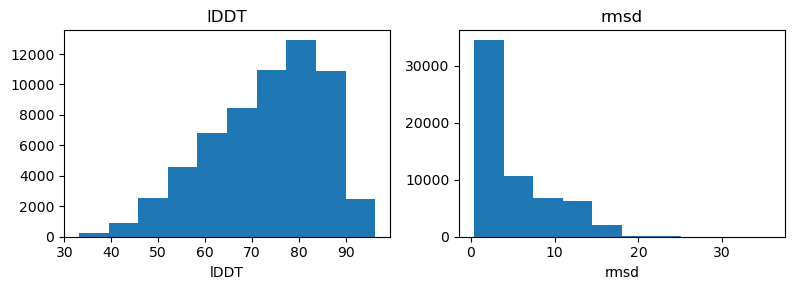

Plotting lDDT vs rmsd.


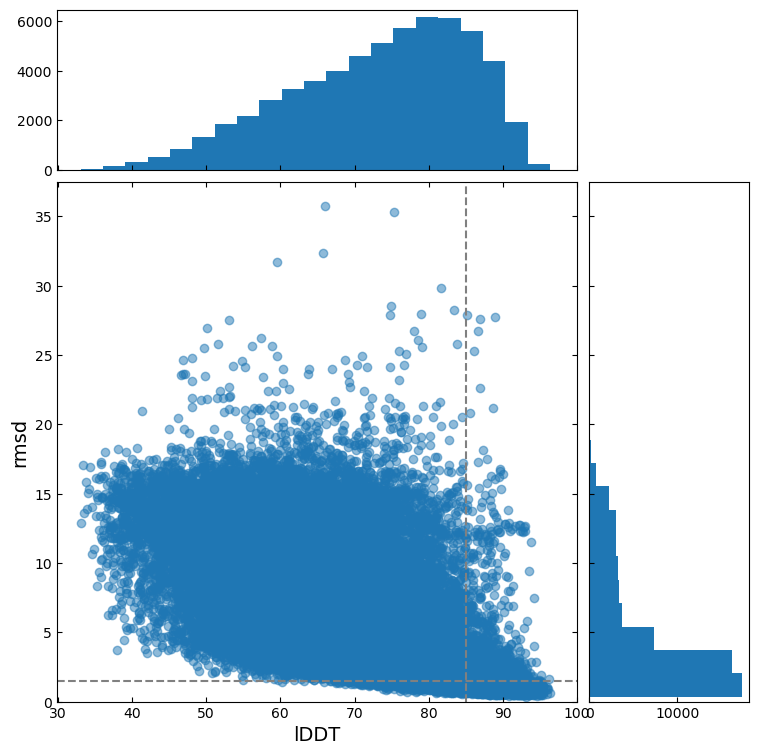

In [7]:
scores_af2 = pd.read_csv("scores.sc", sep="\s+", header=0)

print(scores_af2)

### Filtering AF2 scores based on lddt and rmsd
# Define your desired cutoffs here:
AF2_filters = {"lDDT": [85.0, ">="],
               "rmsd": [1.5, "<="]} # further modifications here, there used to be a statistic measuring RMSD of the cat residue.

scores_af2_filtered = utils.filter_scores(scores_af2, AF2_filters)
utils.dump_scorefile(scores_af2_filtered, "filtered_scores.sc")

## Plotting AF2 scores
plt.figure(figsize=(12, 3))
for i,k in enumerate(AF2_filters):
    plt.subplot(1, 3, i+1)
    plt.hist(scores_af2[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()
    
utils.plot_score_pairs(scores_af2, "lDDT", "rmsd", AF2_filters["lDDT"][0], AF2_filters["rmsd"][0])

In [8]:
### Copying good predictions to a separate directory, or replaced by section 2.2 UPDATE: Don't do that.
os.chdir(AF2_DIR)

if len(scores_af2_filtered) > 0:
    os.makedirs("good", exist_ok=True)
    good_af2_models = [row["Output_PDB"]+".pdb" for idx,row in scores_af2_filtered.iterrows()]
    for pdb in good_af2_models:
        copy2(pdb, f"good/{pdb}")
    good_af2_models = glob.glob(f"{AF2_DIR}/good/*.pdb")
else:
    sys.exit("No good models to continue this pipeline with")

os.chdir(f"{AF2_DIR}/good")


### Aligning the ligand back into the AF2 predictions.
### This is done by aligning the AF2 model to diffusion output and copying over the ligand using PyRosetta.
### --fix_catres option will readjust the rotamer and tautomer of 
### any catalytic residue to be the same as in the reference model.

# Why on earth is outdir specified as with_heme2 and not with_heme? The next cell can't find the folder if you do that.
# or replaced by section 2.2
# UPDATE:Please ignore the line above as section 2.2 not gonna work. For reason, please check project diary.
align_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/utils/place_ligand_after_af2.py "\
            f"--outdir with_heme --params {' '.join(params)} --fix_catres "\
            f"--pdb {' '.join(good_af2_models)} "\
            f"--ref {' '.join(glob.glob(DIFFUSION_DIR+'/filtered_structures/*.pdb'))}"

### script creating line seems missing, ending in creating a new submit_design.sh in 'good' directory and may cause confusion:
submit_script = "submit_realign.sh"

# Ain't no way we're running this whole thing through a subprocess on jupyterhub, so I guess we make our own submit script.267180[].pbs-7
utils.create_slurm_submit_script(filename=submit_script, name="submit_realign",
                                 mem="64g", N_cores=2, time="0:20:00", email=EMAIL,
                                 command=align_cmd, outfile_name="submit_realign") # This script requires an obscene amount of memory. 920 gb is the max to stay on the Short queue.


print('Done. Go submit the script')
#p = subprocess.Popen(align_cmd, shell=True)
#(output, err) = p.communicate()

Done. Go submit the script


## 3.1: Performing binding site design with ligandMPNN / FastRelax
(see 3.2 down below for design with [Rosetta FastDesign](#Rosetta_design))

If you are designing for specific conformer, please use `***.py`. This version will significantly lower the success rate in design but keep your conformational integrity. I recommand a $PBS ARRAY (J) at least 1-5

In [10]:
### Setting up design directory and commands
os.chdir(WDIR)
DESIGN_DIR_ligMPNN = f"{WDIR}/3.1_ligandMPNN_new"

os.makedirs(DESIGN_DIR_ligMPNN, exist_ok=True)
os.chdir(DESIGN_DIR_ligMPNN)

AF2_DIR = f"{WDIR}/2_af2_new"

os.makedirs(DESIGN_DIR_ligMPNN+"/logs", exist_ok=True)

### Performing 5 design iterations on each input structure
NSTRUCT = 5
#cstfile = f"{SCRIPT_DIR}/theozyme/HBA/HBA_CYS_UPO.cst"

commands_design = []
cmds_filename_des = "commands_design"
with open(cmds_filename_des, "w") as file:
    for pdb in glob.glob(f"{AF2_DIR}/good/with_heme/*.pdb"):
        commands_design.append(f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/heme_pocket_ligMPNN.py "
                             f"--pdb {pdb} --nstruct {NSTRUCT} "
                             f"--scoring {SCRIPT_DIR}/scripts/design/scoring/heme_scoring.py "
                             f"--params {' '.join(params)} > logs/{os.path.basename(pdb).replace('.pdb', '.log')}\n") # We've removed --cstfile {cstfile}
        file.write(commands_design[-1])

print("Example design command:")
print(commands_design[-1])


### Running design jobs with Slurm.
submit_script = "submit_design.sh"
utils.create_slurm_submit_script(filename=submit_script, name="3.1_design_pocket_ligMPNN", mem="4g", gpu=True, group=50, 
                                 N_cores=1, time="3:00:00", email=EMAIL, array=len(commands_design),
                                 array_commandfile=cmds_filename_des)

#if not os.path.exists(DESIGN_DIR_ligMPNN+"/.done"):
#    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#    (output, err) = p.communicate()
print('!! Remember! Have you added `export LD_LIBRARY_PATH=$CONDA_PREFIX/lib:$LD_LIBRARY_PATH` after conda activation line?')

Example design command:
/rds/general/user/wh621/home/miniforge3/envs/diffusion/bin/python /rds/general/user/wh621/home/heme_binder_diffusion/scripts/design/heme_pocket_ligMPNN.py --pdb /rds/general/user/wh621/home/heme_binder_diffusion/output/2_af2_new/good/with_heme/pcb1438_job29_dif_35_traj4_T0.3_0_53_model_4.0_r3_af2_PCB.pdb --nstruct 5 --scoring /rds/general/user/wh621/home/heme_binder_diffusion/scripts/design/scoring/heme_scoring.py --params /rds/general/user/wh621/home/heme_binder_diffusion/theozyme/PCB/PCB.params > logs/pcb1438_job29_dif_35_traj4_T0.3_0_53_model_4.0_r3_af2_PCB.log

!! Remember! Have you added `export LD_LIBRARY_PATH=$CONDA_PREFIX/lib:$LD_LIBRARY_PATH` after conda activation line?


In [12]:
## If you're done with design and happy with the outputs then mark it as done
DESIGN_DIR_ligMPNN = f"{WDIR}/3.1_ligandMPNN"

os.chdir(DESIGN_DIR_ligMPNN)

if not os.path.exists(DESIGN_DIR_ligMPNN+"/.done"):
    with open(f"{DESIGN_DIR_ligMPNN}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

### Analyzing ligMPNN / FastRelax design results

nlr_totrms               <=   1.000: 1513 items left. 1513 pass (100%).
L_SASA                   <=   0.200: 1513 items left. 1513 pass (100%).
score_per_res            <=   0.000: 1513 items left. 1513 pass (100%).
cms_per_atom             >=   0.480: 1513 items left. 1513 pass (100%).


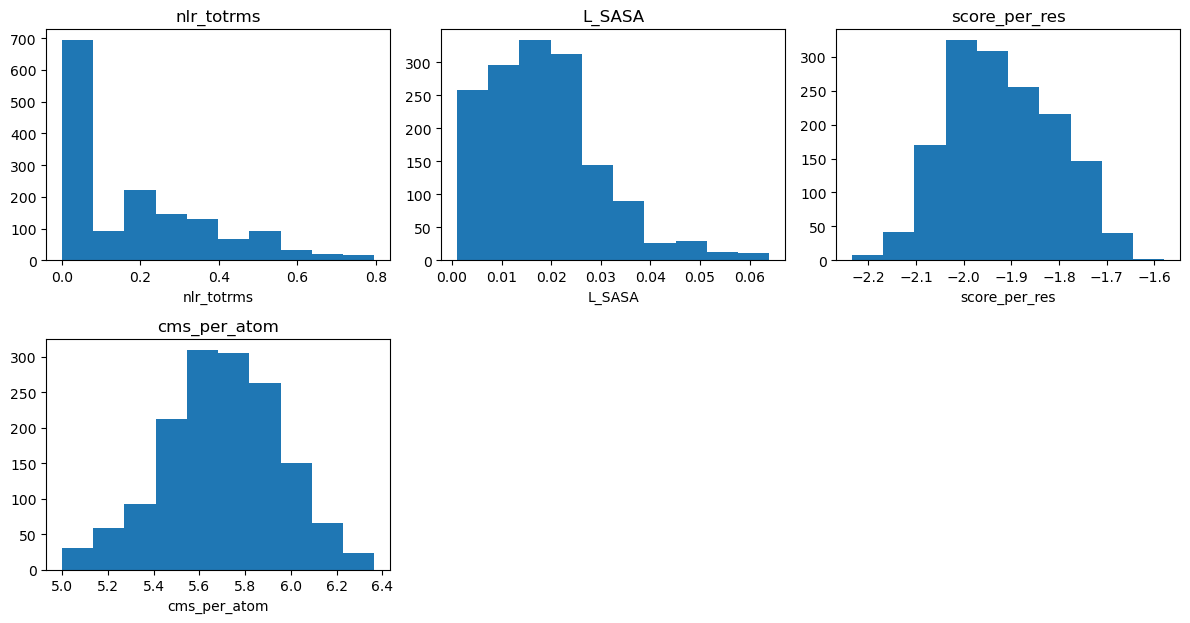

In [13]:
## Analyzing ligMPNN / FastRelax designs
##modify this calculator for PCB.
if not os.path.exists("scorefile.txt"):
    sys.exit("Design job failed, or no successful outputs were produced.")

scores = pd.read_csv("scorefile.txt", sep="\s+", header=0)

filters = {#'all_cst': [10.0, '<='],
# 'nlr_SR1_rms': [0.8, '<='],
 'nlr_totrms': [1.0, '<='], # passes
 'L_SASA': [0.2, '<='], # Passes
# 'COO_hbond': [1.0, '<='], # Passes, 1 or 0
# 'heme_angle_wrst': [80.0, '>='],
 'score_per_res': [0.0, '<='], # Passes
# 'corrected_ddg': [50.0, '<='],
 'cms_per_atom': [0.48, '>=']} # Passes

filtered_scores = utils.filter_scores(scores, filters)

### Copying good designs over to a new directory
if len(filtered_scores) > 0:
    os.makedirs(f"{DESIGN_DIR_ligMPNN}/good")
    for idx, row in filtered_scores.iterrows():
        copy2(row["description"]+".pdb", "good/"+row["description"]+".pdb")
else:
    print("No good designs created, bummer...")

## Plotting AF2 scores
plt.figure(figsize=(12, 9))
for i,k in enumerate(filters):
    plt.subplot(3, 3, i+1)
    plt.hist(scores[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()

## 4.1 Performing ligandMPNN redesign on the 2nd layer residues

Resampling residues that are not in the pocket, but also not very far from the pocket

In [17]:
DESIGN_DIR_ligMPNN = f"{WDIR}/3.1_repeat"
if len(glob.glob(DESIGN_DIR_ligMPNN+'/good/*.pdb')) == 0:
    sys.exit("No designs to run 2nd MPNN on.")

os.chdir(WDIR)
DESIGN_DIR_2nd_mpnn = f"{WDIR}/4.1_2nd_mpnn"

os.makedirs(DESIGN_DIR_2nd_mpnn, exist_ok=True)
os.chdir(DESIGN_DIR_2nd_mpnn)

### Making a JSON file specifiying designable positions for each structure.
### Will also make non-pocket ALA positions as designable.
### This is to fix any surface ALA-patches that previous MPNN may have introduced.

make_json_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/setup_ligand_mpnn_2nd_layer.py "\
                f"--params {' '.join(params)} --ligand {LIGAND} --output_path parsed_pdbs_lig.jsonl "\
                 "--output_path masked_pos.jsonl --dist_bb 6.0 --dist_sc 5.0 "\
                f"--pdb {' '.join(glob.glob(DESIGN_DIR_ligMPNN+'/good/*.pdb'))}"

submit_script = "submit_jsonl.sh"
utils.create_slurm_submit_script(filename=submit_script, name="4.1_2nd_mpnn",
                                 mem="64g", N_cores=1, time="0:20:00", email=EMAIL,
                                 command=make_json_cmd, outfile_name="output_analysis") # We have to make a PBS script here.
!cat "submit_jsonl.sh" # I just want to print it first to make sure it has been generated properly
#p = subprocess.Popen(make_json_cmd, shell=True)
#(output, err) = p.communicate()

#!/bin/bash
#PBS -l walltime=08:00:00
#PBS -l select=1:ncpus=1:mem=64gb
module load miniforge/3
module load CUDA/12.6.0
eval "$(~/miniforge3/bin/conda shell.bash hook)"
conda activate /rds/general/user/wh621/home/miniforge3/envs/diffusion
cd $PBS_O_WORKDIR
echo 'Starting at:' $(date +%F) $(date +%T)
/rds/general/user/wh621/home/miniforge3/envs/diffusion/bin/python /rds/general/user/wh621/home/heme_binder_diffusion/scripts/design/setup_ligand_mpnn_2nd_layer.py --params /rds/general/user/wh621/home/heme_binder_diffusion/theozyme/PCB/PCB.params --ligand PCB --output_path parsed_pdbs_lig.jsonl --output_path masked_pos.jsonl --dist_bb 6.0 --dist_sc 5.0 --pdb /rds/general/user/wh621/home/heme_binder_diffusion/output/3.1_repeat/good/1_dif_39_traj1_T0.3_0_68_model_4.0_r3_af2_PCB_mDE_19.pdb /rds/general/user/wh621/home/heme_binder_diffusion/output/3.1_repeat/good/1_dif_39_traj4_T0.3_0_7_model_4.0_r3_af2_PCB_mDE_04.pdb /rds/general/user/wh621/home/heme_binder_diffusion/output/3.1_repeat/good/1_d

In [18]:
### Setting up ligandMPNN run commands
## We're doing design with 2 temperatures (more conservative than before), and 5 sequences each.

MPNN_temperatures = [0.1, 0.2]
MPNN_outputs_per_temperature = 5
MPNN_omit_AAs = "CM"

commands_mpnn = []
cmds_filename_mpnn = "commands_mpnn"
with open(cmds_filename_mpnn, "w") as file:
    for T in MPNN_temperatures:
        for f in glob.glob(DESIGN_DIR_ligMPNN+'/good/*.pdb'):
            commands_mpnn.append(f"{PYTHON['proteinMPNN']} {proteinMPNN_script} "
                                 f"--model_type ligand_mpnn --ligand_mpnn_use_atom_context 1 "
                                 "--fixed_residues_multi masked_pos.jsonl --out_folder ./ "
                                 f"--number_of_batches {MPNN_outputs_per_temperature} --temperature {T} "
                                 f"--omit_AA {MPNN_omit_AAs} --pdb_path {f} " # Space added and checkpoint_protein_mpnn altered to checkpoijnt_ligand_mpnn
                                 f"--checkpoint_ligand_mpnn {SCRIPT_DIR}/lib/LigandMPNN/model_params/ligandmpnn_v_32_010_25.pt\n")
            file.write(commands_mpnn[-1])

print("Example MPNN command:")
print(commands_mpnn[-1])

### Running ligandMPNN with Slurm.
### Grouping jobs with 10 commands per one array job.

submit_script = "submit_mpnn.sh"
utils.create_slurm_submit_script(filename=submit_script, name="4.1_2nd_mpnn", mem="8g", gpu=True, 
                                 N_cores=1, time="0:15:00", email=EMAIL, array=len(commands_mpnn),
                                 array_commandfile=cmds_filename_mpnn, group=1000)

#if not os.path.exists(DESIGN_DIR_2nd_mpnn+"/.done"):
#    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#    (output, err) = p.communicate()

Example MPNN command:
/rds/general/user/wh621/home/miniforge3/envs/diffusion/bin/python /rds/general/user/wh621/home/heme_binder_diffusion/lib/LigandMPNN/run.py --model_type ligand_mpnn --ligand_mpnn_use_atom_context 1 --fixed_residues_multi masked_pos.jsonl --out_folder ./ --number_of_batches 5 --temperature 0.2 --omit_AA CM --pdb_path /rds/general/user/wh621/home/heme_binder_diffusion/output/3.1_repeat/good/1_dif_39_traj1_T0.3_0_63_model_4.0_r3_af2_PCB_mDE_06.pdb --checkpoint_ligand_mpnn /rds/general/user/wh621/home/heme_binder_diffusion/lib/LigandMPNN/model_params/ligandmpnn_v_32_010_25.pt



## 5.1 AlphaFold2 predictions on the 2nd MPNN run

In [28]:
os.chdir(WDIR)
DESIGN_DIR_2nd_mpnn = f"{WDIR}/4.1_2nd_mpnn"

# assert os.path.exists(DESIGN_DIR_2nd_mpnn+"/.done"), "2nd MPNN has not been performed!"
# There is defo a codeblock missing above that creates .done

AF2_DIR = f"{WDIR}/5.1_2nd_af2"

os.makedirs(AF2_DIR, exist_ok=True)
os.chdir(AF2_DIR)

### First collecting MPNN outputs and creating FASTA files for AF2 input
mpnn_fasta = utils.parse_fasta_files(glob.glob(f"{DESIGN_DIR_2nd_mpnn}/seqs/*.fa"))
# Giving sequences unique names based on input PDB name, temperature, and sequence identifier
_mpnn_fasta = {}
for k, seq in mpnn_fasta.items():
    if "model_path" in k:
        _mpnn_fasta[k.split(",")[0]+"_native"] = seq.strip()
    else:
        _mpnn_fasta[k.split(",")[0]+"_"+k.split(",")[2].replace(" T=", "T")+"_0_"+k.split(",")[1].replace(" id=", "")] = seq.strip()
mpnn_fasta = {k:v for k,v in _mpnn_fasta.items()}

print(f"A total on {len(mpnn_fasta)} sequences will be predicted.")

## Splitting the MPNN sequences based on length
## and grouping them in smaller batches for each AF2 job
## Use group size of >40 when running on GPU. Also depends on how many sequences and resources you have.
SEQUENCES_PER_AF2_JOB = 5  # CPU
if USE_GPU_for_AF2 is True:
    SEQUENCES_PER_AF2_JOB = 50  # GPU
mpnn_fasta_split = utils.split_fasta_based_on_length(mpnn_fasta, SEQUENCES_PER_AF2_JOB, write_files=True)

A total on 9078 sequences will be predicted.
Duplicate sequence: >1_dif_39_traj3_T0.3_0_52_model_4.0_r3_af2_PCB_mDE_08_native
Duplicate sequence: >1_dif_39_traj4_T0.3_0_21_model_4.0_r3_af2_PCB_mDE_18_native
2 duplicate sequences removed.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 sequences of 113 length.
50 seq

In [29]:
## Setting up AlphaFold2 run

AF2_recycles = 3
AF2_models = "4"  # add other models to this string if needed

commands_af2 = []
cmds_filename_af2 = "commands_af2"
with open(cmds_filename_af2, "w") as file:
    for ff in glob.glob("*.fasta"):
        commands_af2.append(f"{PYTHON['af2']} {AF2_script} "
                             f"--af-nrecycles {AF2_recycles} --af-models {AF2_models} "
                             f"--fasta {ff} --scorefile {ff.replace('.fasta', '.csv')}\n")
        file.write(commands_af2[-1])

print("Example AF2 command:")
print(commands_af2[-1])

### Running AF2 with Slurm.
### Running jobs on the CPU. It takes ~10 minutes per sequence

submit_script = "submit_af2.sh"
if USE_GPU_for_AF2 is True:
    utils.create_slurm_submit_script(filename=submit_script, name="5.1_2nd_af2", mem="6g", 
                                     N_cores=2, gpu=True, gres="gpu:rtx2080:1", time="00:12:00", email=EMAIL, array=len(commands_af2),
                                     array_commandfile=cmds_filename_af2, env="mlfold")
else:
    utils.create_slurm_submit_script(filename=submit_script, name="5.1_2nd_af2", mem="6g", 
                                     N_cores=4, time="01:00:00", email=EMAIL, array=len(commands_af2),
                                     array_commandfile=cmds_filename_af2)

#if not os.path.exists(AF2_DIR+"/.done"):
#    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#    (output, err) = p.communicate()

Example AF2 command:
/rds/general/user/wh621/home/miniforge3/envs/mlfold/bin/python /rds/general/user/wh621/home/heme_binder_diffusion/scripts/af2/af2.py --af-nrecycles 3 --af-models 4 --fasta 113aa_139.fasta --scorefile 113aa_139.csv



In [28]:
## If you're done with AF2 and happy with the outputs then mark it as done
AF2_DIR = f"{WDIR}/5.1_2nd_af2"

os.chdir(AF2_DIR)

DESIGN_DIR_ligMPNN = f"{WDIR}/3.1_ligandMPNN"
if not os.path.exists(AF2_DIR+"/.done"):
    with open(f"{AF2_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

### Analyzing AlphaFold2 predictions

In [10]:
# Combining all CSV scorefiles into one
os.system("head -n 1 $(ls *aa*.csv | shuf -n 1) > scores.csv ; for f in *aa*.csv ; do tail -n +2 ${f} >> scores.csv ; done")
assert os.path.exists("scores.csv"), "Could not combine scorefiles"

### Calculating the RMSDs of AF2 predictions relative to the diffusion outputs
### Catalytic residue sidechain RMSDs are calculated in the reference PDB has REMARK 666 line present

analysis_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/utils/analyze_af2.py --scorefile scores.csv "\
               f"--ref_path {DESIGN_DIR_ligMPNN}/good/ --mpnn --params {' '.join(params)}"

submit_script = "submit_af2_analysis.sh"
utils.create_slurm_submit_script(filename=submit_script, name="af2_analysis",
                                 mem="16g", N_cores=8, time="0:20:00", email=EMAIL,
                                 command=analysis_cmd, outfile_name="output_analysis")

print("Done! Submit submit_af2_analysis.sh before proceed!")

#p = subprocess.Popen(analysis_cmd, shell=True)
#(output, err) = p.communicate()

Done! Submit submit_af2_analysis.sh before proceed!


lDDT                     >=  85.000: 131 items left. 131 pass (1%).
rmsd                     <=   1.200: 32 items left. 41 pass (0%).
Plotting lDDT vs rmsd.


<Figure size 1200x300 with 0 Axes>

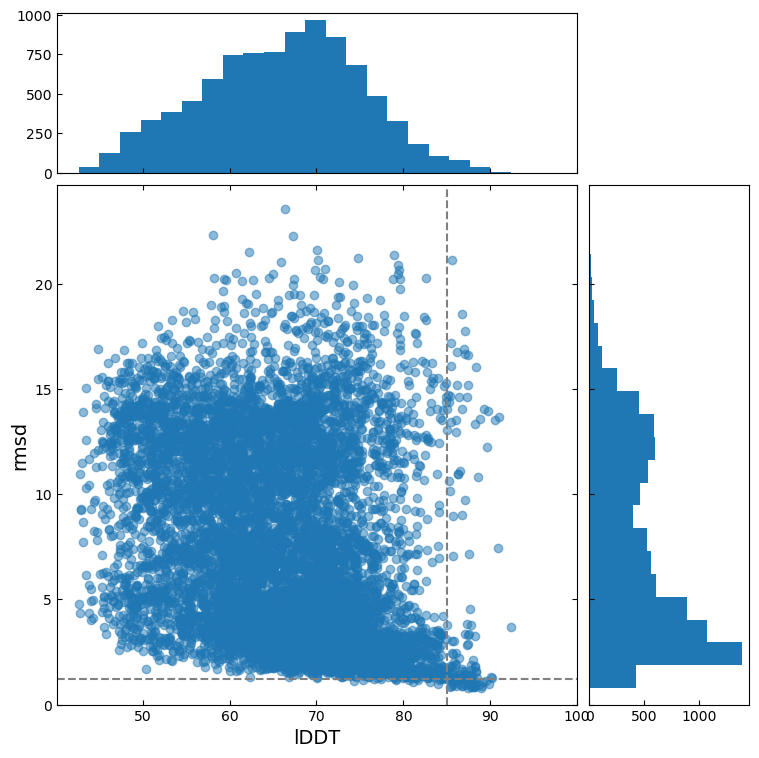

In [33]:
### Visualizing and filtering AF2 results

AF2_DIR = f"{WDIR}/5.1_2nd_af2"
os.chdir(AF2_DIR)

scores_af2 = pd.read_csv("scores.sc", sep="\s+", header=0)

### Filtering AF2 scores based on lddt and rmsd
# Define your desired cutoffs here:
AF2_filters = {"lDDT": [85.0, ">="],
               "rmsd": [1.2, "<="],
               "rmsd_SR1": [1.0, "<="]}  # 1st catalytic residue sc-rmsd

scores_af2_filtered = utils.filter_scores(scores_af2, AF2_filters)
utils.dump_scorefile(scores_af2_filtered, "filtered_scores.sc")

## Plotting AF2 scores
plt.figure(figsize=(12, 3))
#for i,k in enumerate(AF2_filters):
#    plt.subplot(1, 3, i+1)
#    plt.hist(scores_af2[k])
#    plt.title(k)
#    plt.xlabel(k)
#plt.tight_layout()
#plt.show()

utils.plot_score_pairs(scores_af2, "lDDT", "rmsd", AF2_filters["lDDT"][0], AF2_filters["rmsd"][0])

In [34]:
### Copying good predictions to a separate directory
os.chdir(AF2_DIR)

if len(scores_af2_filtered) > 0:
    os.makedirs("good", exist_ok=True)
    good_af2_models = [row["Output_PDB"]+".pdb" for idx,row in scores_af2_filtered.iterrows()]
    for pdb in good_af2_models:
        copy2(pdb, f"good/{pdb}")
    good_af2_models = glob.glob(f"{AF2_DIR}/good/*.pdb")
    print("Done!")
else:
    sys.exit("No good models to continue this pipeline with")


Done!


## 6.1: Final FastRelax with the ligand
Relaxing good AF2 models together with the ligand


In [35]:
AF2_DIR = f"{WDIR}/5.1_2nd_af2"
DESIGN_DIR_ligMPNN = f"{WDIR}/3.1_ligandMPNN"
RELAX_DIR = f"{WDIR}/6.1_final_relax"


assert len(glob.glob(f"{AF2_DIR}/good/*.pdb")) > 0, "No good AF2 models to relax with"

os.chdir(WDIR)

os.makedirs(RELAX_DIR, exist_ok=True)
os.chdir(RELAX_DIR)

os.makedirs(RELAX_DIR+"/logs", exist_ok=True)

## First matching up the AF2 output filenames of step 5 with pocket design filenames from step 3
ref_and_model_pairs = []
for r in glob.glob(f"{DESIGN_DIR_ligMPNN}/good/*.pdb"):
    for pdbfile in glob.glob(f"{AF2_DIR}/good/*.pdb"):
        if os.path.basename(r).replace(".pdb", "_") in pdbfile:
            ref_and_model_pairs.append((r, pdbfile))

assert len(ref_and_model_pairs) == len(glob.glob(f"{AF2_DIR}/good/*.pdb")), "Was not able to match all models with reference structures"


## Generating commands for relax jobs
### Performing 1 relax iteration on each input structure
NSTRUCT = 1
cstfile = f"{SCRIPT_DIR}/theozyme/HBA/HBA_CYS_UPO.cst"

commands_relax = []
cmds_filename_rlx = "commands_relax"
with open(cmds_filename_rlx, "w") as file:
    for r_m in ref_and_model_pairs:
        commands_relax.append(f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/align_add_ligand_relax.py "
                              f"--outdir ./ --ligand {LIGAND} --ref_pdb {r_m[0]} "
                              f"--pdb {r_m[1]} --nstruct {NSTRUCT} "
                              f"--params {' '.join(params)} > logs/{os.path.basename(r_m[1]).replace('.pdb', '.log')}\n") # Reference to cstfile removed (--cstfile {cstfile})
        file.write(commands_relax[-1])

print("Example design command:")
print(commands_relax[-1])


### Running design jobs with Slurm.
submit_script = "submit_relax.sh"
utils.create_slurm_submit_script(filename=submit_script, name="6.1_final_relax", mem="16g", 
                                 N_cores=1, time="0:30:00", email=EMAIL, array=len(commands_relax), group=10, 
                                 array_commandfile=cmds_filename_rlx)

print("Done! Have you added `export LD_LIBRARY_PATH=$CONDA_PREFIX/lib:$LD_LIBRARY_PATH` after conda activate diffusion?")
                              
#if not os.path.exists(RELAX_DIR+"/.done"):
#    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#    (output, err) = p.communicate()

Example design command:
/rds/general/user/wh621/home/miniforge3/envs/diffusion/bin/python /rds/general/user/wh621/home/heme_binder_diffusion/scripts/design/align_add_ligand_relax.py --outdir ./ --ligand PCB --ref_pdb /rds/general/user/wh621/home/heme_binder_diffusion/output/3.1_repeat/good/1_dif_39_traj4_T0.3_0_49_model_4.0_r3_af2_PCB_mDE_07.pdb --pdb /rds/general/user/wh621/home/heme_binder_diffusion/output/5.1_repeat/good/1_dif_39_traj4_T0.3_0_49_model_4.0_r3_af2_PCB_mDE_07_T0.2_0_4_model_4.0_r3_af2.pdb --nstruct 1 --params /rds/general/user/wh621/home/heme_binder_diffusion/theozyme/PCB/PCB.params > logs/1_dif_39_traj4_T0.3_0_49_model_4.0_r3_af2_PCB_mDE_07_T0.2_0_4_model_4.0_r3_af2.log

Done! Have you added `export LD_LIBRARY_PATH=$CONDA_PREFIX/lib:$LD_LIBRARY_PATH` after conda activate diffusion?


In [37]:
## If you're done with final relax and happy with the outputs then mark it as done
RELAX_DIR = f"{WDIR}/6.1_final_relax"
os.chdir(RELAX_DIR)

if not os.path.exists(RELAX_DIR+"/.done"):
    with open(f"{RELAX_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

### Analyzing final relaxed structures
Filtering them based on the same metrics as was used for the initial design

L_SASA                   <=   0.200: 32 items left. 32 pass (100%).
score_per_res            <=   0.000: 32 items left. 32 pass (100%).
rmsd_CA_rlx_in           <=   1.000: 29 items left. 29 pass (91%).


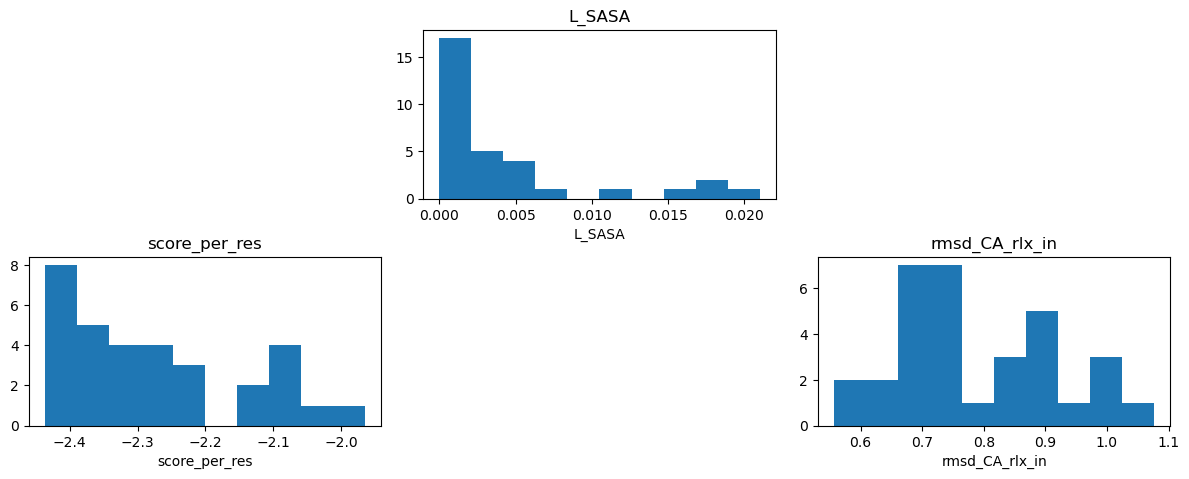

In [39]:
## Analyzing Rosetta designs
RELAX_DIR = f"{WDIR}/6.1_final_relax"

os.chdir(RELAX_DIR)

scores = pd.read_csv("scorefile.txt", sep="\s+", header=0)

filters = {#'all_cst': [1.0, '<='],
# 'nlr_SR1_rms': [0.8, '<='],
 'nlr_totrms': [1.0, '<='],
 'L_SASA': [0.2, '<='],
 'COO_hbond': [1.0, '='],
# 'heme_angle_wrst': [80.0, '>='],
 'score_per_res': [0.0, '<='],
# 'corrected_ddg': [-50.0, '<='],
 'cms_per_atom': [4.8, '>='],
 'rmsd_CA_rlx_in': [1.0, "<="]}  # rmsd_CA_rlx_in is rmsd between relaxed structure and AF2 prediction

filtered_scores = utils.filter_scores(scores, filters)

## Plotting relax scores
plt.figure(figsize=(12, 9))
for i,k in enumerate(filters):
    if k not in scores.keys():
        continue
    plt.subplot(4, 3, i+1)
    plt.hist(scores[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()

### Copying good designs over to a new directory
if len(filtered_scores) > 0:
    os.makedirs(f"{RELAX_DIR}/good", exist_ok=True)
    for idx, row in filtered_scores.iterrows():
        copy2(row["description"]+".pdb", "good/"+row["description"]+".pdb")
else:
    print("No good designs created, bummer...")

In [24]:
## Setting up general settings for caving
'''
CAVER_DIR = f"{WDIR}/7_caver"
if not os.path.exists(CAVER_DIR):
    os.makedirs(CAVER_DIR, exist_ok=False)

os.chdir(CAVER_DIR)

caver_inputs = glob.glob(f"{RELAX_DIR}/good/*.pdb")
print(f"Found {len(caver_inputs)} PDB files")

caver_config = f"""
# CALCULATION SETUP      
load_tunnels no
load_cluster_tree no

# INPUT DATA
time_sparsity 1
first_frame 1
last_frame 10
include_residue_names 20_AA

# TUNNEL CALCULATION
starting_point_coordinates 0.0 0.0 0.0
probe_radius 0.9
shell_radius 3
shell_depth 4 

# TUNNEL CLUSTERING
clustering average_link
weighting_coefficient 1
clustering_threshold 3.5

# GENERATION OF OUTPUTS
one_tunnel_in_snapshot cheapest
save_dynamics_visualization yes

generate_summary yes
generate_tunnel_characteristics yes
generate_tunnel_profiles yes

generate_histograms yes
bottleneck_histogram 0.0 2.0 20
throughput_histogram 0 1.0 10

generate_bottleneck_heat_map yes
bottleneck_heat_map_range 1.0 2.0
bottleneck_heat_map_element_size 10 20

generate_profile_heat_map yes
profile_heat_map_resolution 0.5
profile_heat_map_range 1.0 2.0
profile_heat_map_element_size 20 10

compute_tunnel_residues yes
residue_contact_distance 3.0

compute_bottleneck_residues yes
bottleneck_contact_distance 3.0


# ADVANCED SETTINGS
number_of_approximating_balls 12
compute_errors no
save_error_profiles no
path_to_vmd "C:/Program Files/University of Illinois/VMD/vmd.exe"
generate_trajectory yes
swap no
seed 1

"""

with open("config.txt", "w") as file:
    file.write(caver_config)
print(f"Wrote config file to {os.path.realpath('config.txt')}")

commands_caver = []
caver_rundirs = []
cmds_filename = "commands_caver"
      
with open(cmds_filename, "w") as file:
    for p in caver_inputs:
        pdbname = os.path.basename(p).replace(".pdb", "")
        os.makedirs(pdbname, exist_ok=True)
        copy2(p, pdbname + "/" + pdbname + ".pdb")
        cmd = f"java -Xmx1200m -cp ../../lib/caver/lib -jar ../../lib/caver/caver.jar "\
              f"-home ../../lib/caver -pdb ./{pdbname} -conf ./config.txt -out ./{pdbname}\n"
        commands_caver.append(cmd)
        caver_rundirs.append(pdbname)
        file.write(cmd)

print(f"An example caver command that was generated:\n   {cmd}")
      
submit_script = "submit_caver.sh"
utils.create_slurm_submit_script(filename=submit_script, name="caver", 
                                 mem="4g", N_cores=1, time="1:00", email=EMAIL, group=10,
                                 array=len(commands_caver), array_commandfile=cmds_filename)
'''
#  Sorry I am disabling it temporarily.                             

Found 24 PDB files
Wrote config file to /rds/general/user/wh621/home/heme_binder_diffusion/output/7_caver/config.txt
An example caver command that was generated:
   java -Xmx1200m -cp ../../lib/caver/lib -jar ../../lib/caver/caver.jar -home ../../lib/caver -pdb ./7_dif_17_traj3_T0.2_0_5_model_4.0_r3_af2_PCB_mDE_5_T0.2_0_3_model_4.0_r3_af2_PCB_rlx_0 -conf ./config.txt -out ./7_dif_17_traj3_T0.2_0_5_model_4.0_r3_af2_PCB_mDE_5_T0.2_0_3_model_4.0_r3_af2_PCB_rlx_0



In [40]:
if len(filtered_scores) > 0:
    print(f"CONGRATULATIONS! You have successfully designed {len(filtered_scores)} proteins against ligand {LIGAND}")
    print("You can find the design models in the directory:\n"
          f"    {RELAX_DIR}/good")
    print("\nIt is advised you manually inspect them before ordering.")

CONGRATULATIONS! You have successfully designed 29 proteins against ligand PCB
You can find the design models in the directory:
    /rds/general/user/wh621/home/heme_binder_diffusion/output/6.1_repeat/good

It is advised you manually inspect them before ordering.


### 8.1 Protenix ( on 2025 06 26: Check Section 8.2 for Boltz-2 instead)
 To make the results more reliable, We need to validate and filter the final results predicted from alphafold2 before go into wetlab. Logic here: 
1. Strip the protein sequence from `{WDIR}/6.1_final_relax/good/`;
2. Input the sequence and ligand mol2 file(blind conformational information) as `json`to Protenix;
3. Running Protenix using `constraint_esm` branch instead of `msa`;
4. Convert `.cif` results back to `.pdb` file by `BeEM`(https://github.com/kad-ecoli/BeEM);
5. Screen the output Json files to transfer the predicts with protein_plddt >= 0.90, ligand_plddt >= 0.85 only to `good` directory;
6. Compare ligand rmsd by each atom and angle calculators. 

Notice: To run Protenix, we need to activate **pipeline** environment instead of diffusion in PBS submitting script.

In [41]:
## Step 1: Converting filtered good pdb structures to fasta sequence

INPUT_DIR = f"{WDIR}/6.1_final_relax/good/"
SEQUENCE_DIR = f"{WDIR}/8.1_Protenix/input_sequences/"

os.makedirs(SEQUENCE_DIR, exist_ok=True)

# Initialize the PDB parser and the polypeptide builder
parser = PDBParser(QUIET=True)
ppb = PPBuilder()

# Loop over each pdb file in the input directory
for pdb_file in glob.glob(os.path.join(INPUT_DIR, "*.pdb")):
    structure = parser.get_structure("struct", pdb_file)
    
    seq = ""
    model = next(structure.get_models())
    if "A" in model:
        chain = model["A"]
        # Build peptides from the chain (in case there are breaks)
        for pp in ppb.build_peptides(chain):
            seq += str(pp.get_sequence())
    else:
        print(f"Chain A not found in {pdb_file}. Skipping...")
        continue

    # Create the output FASTA file name by replacing .pdb with .fa
    base_name = os.path.basename(pdb_file).replace(".pdb", "")
    fasta_file = os.path.join(SEQUENCE_DIR, f"{base_name}.fa")
    
    # Write the sequence in FASTA format
    with open(fasta_file, "w") as out_f:
        out_f.write(f">{base_name}\n")
        for i in range(0, len(seq), 10):
            out_f.write(seq[i:i+10] + "\n")
    
    print(f"Extracted sequence for {pdb_file} -> {fasta_file}")

fasta_files = glob.glob(os.path.join(SEQUENCE_DIR, "*.fa"))
print(f"Found {len(fasta_files)} FASTA files in {SEQUENCE_DIR}.")

Extracted sequence for /rds/general/user/wh621/home/heme_binder_diffusion/output/6.1_repeat/good/1_dif_39_traj3_T0.3_0_21_model_4.0_r3_af2_PCB_mDE_10_T0.1_0_2_model_4.0_r3_af2_PCB_rlx_0.pdb -> /rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_repeat/input_sequences/1_dif_39_traj3_T0.3_0_21_model_4.0_r3_af2_PCB_mDE_10_T0.1_0_2_model_4.0_r3_af2_PCB_rlx_0.fa
Extracted sequence for /rds/general/user/wh621/home/heme_binder_diffusion/output/6.1_repeat/good/1_dif_39_traj3_T0.3_0_21_model_4.0_r3_af2_PCB_mDE_16_T0.1_0_5_model_4.0_r3_af2_PCB_rlx_0.pdb -> /rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_repeat/input_sequences/1_dif_39_traj3_T0.3_0_21_model_4.0_r3_af2_PCB_mDE_16_T0.1_0_5_model_4.0_r3_af2_PCB_rlx_0.fa
Extracted sequence for /rds/general/user/wh621/home/heme_binder_diffusion/output/6.1_repeat/good/1_dif_39_traj3_T0.3_0_21_model_4.0_r3_af2_PCB_mDE_02_T0.2_0_5_model_4.0_r3_af2_PCB_rlx_0.pdb -> /rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_repea

In [42]:
## Step 2: Generate JSON input files

# Paths
SEQUENCE_DIR = f"{WDIR}/8.1_Protenix/input_sequences/"
JSON_DIR = f"{WDIR}/8.1_Protenix/input_json"
DUMP_DIR = f"{WDIR}/8.1_Protenix/result"

# Use the reference ligand.mol2 file to match all sequences. Not using sdf file as it don't have atom number. 
LIGAND_FILE = '/rds/general/user/wh621/home/heme_binder_diffusion/theozyme/PCB/PCB.mol2' ## Find it locally and upload first!
Ligand_SMILES= 'C/C=C1C(=C/c2[nH]c(/C=c3\[nH]/c(=C\C4=NC(=O)C(CC)=C4C)c(C)c3CCC(=O)O)c(CCC(=O)O)c2C)/NC(=O)[C@@H]/1C'

def makeProtenixJson(sequence, ligand=None, name="JobName", msadir=None):
    """
    Generates a JSON config for Protenix input.
    
    Args:
        sequence (str): Amino acid sequence (1-letter codes).
        ligand (str or list of str): Path(s) to ligand file(s).
        name (str): Job name (used in Protenix output).
        msadir (str): Optional path to MSA directory.

    Returns:
        str: JSON-formatted string.
    """
    protenixConfig = [
        {
            "sequences": [
                {
                    "proteinChain": {
                        "sequence": sequence,
                        "count": 1
                    }
                }
            ],
            "name": name
        }
    ]
    # Add ligand(s) if specified
    if ligand is not None:
        if isinstance(ligand, str):
            ligand = [ligand]
        for lig in ligand:
            # If it's a path to a file (mol2, sdf, etc.), prefix with "FILE_"
            if os.path.isfile(lig):
                lig = f"FILE_{lig}"
            protenixConfig[0]["sequences"].append({
                "ligand": {
                    "ligand": lig,
                    "count": 1
                }
            })

    # Add MSA directory if specified
    if msadir is not None:
        protenixConfig[0]["sequences"][0]["proteinChain"]["msa"] = {
            "precomputed_msa_dir": msadir,
            "pairing_db": "uniref100"
        }
    return json.dumps(protenixConfig, indent=4)

# Ensure output directories exist
os.makedirs(JSON_DIR, exist_ok=True)
os.makedirs(DUMP_DIR, exist_ok=True)

# Get all .fa files in input directory
fasta_files = glob.glob(os.path.join(SEQUENCE_DIR, "*.fa"))
print(f"Found {len(fasta_files)} FASTA files in {SEQUENCE_DIR}.")

# Process each FASTA file
for fasta_file in fasta_files:
    base_name = os.path.basename(fasta_file)
    name = base_name.replace(".fa", "")

    # Read sequence
    record = next(SeqIO.parse(fasta_file, "fasta"))
    sequence = str(record.seq)
    
    # Generate Protenix JSON
    json_content = makeProtenixJson(sequence=sequence, ligand=LIGAND_FILE, name=name)

    # Save JSON
    json_file_path = os.path.join(JSON_DIR, f"{name}.json")
    with open(json_file_path, "w") as f:
        f.write(json_content)

    print(f"Created JSON for {base_name} -> {json_file_path}")

Found 29 FASTA files in /rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_repeat/input_sequences/.
Created JSON for 1_dif_39_traj3_T0.3_0_21_model_4.0_r3_af2_PCB_mDE_10_T0.1_0_2_model_4.0_r3_af2_PCB_rlx_0.fa -> /rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_repeat/input_json/1_dif_39_traj3_T0.3_0_21_model_4.0_r3_af2_PCB_mDE_10_T0.1_0_2_model_4.0_r3_af2_PCB_rlx_0.json
Created JSON for 1_dif_39_traj3_T0.3_0_21_model_4.0_r3_af2_PCB_mDE_05_T0.2_0_1_model_4.0_r3_af2_PCB_rlx_0.fa -> /rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_repeat/input_json/1_dif_39_traj3_T0.3_0_21_model_4.0_r3_af2_PCB_mDE_05_T0.2_0_1_model_4.0_r3_af2_PCB_rlx_0.json
Created JSON for 1_dif_39_traj3_T0.3_0_21_model_4.0_r3_af2_PCB_mDE_14_T0.1_0_2_model_4.0_r3_af2_PCB_rlx_0.fa -> /rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_repeat/input_json/1_dif_39_traj3_T0.3_0_21_model_4.0_r3_af2_PCB_mDE_14_T0.1_0_2_model_4.0_r3_af2_PCB_rlx_0.json
Created JSON for 1_dif_39_traj3

In [43]:
##Step 3: Running Protenix

JSON_DIR = f"{WDIR}/8.1_Protenix/input_json"
DUMP_DIR = f"{WDIR}/8.1_Protenix/result"


# Find all JSON files
json_files = glob.glob(os.path.join(JSON_DIR, "*.json"))
print("Found " + str(len(json_files)) + " JSON files to process in " + JSON_DIR + ".")

commands_protenix = []
cmds_filename_protenix = os.path.join(DUMP_DIR, "commands_protenix")

# Write commands using linear string style
with open(cmds_filename_protenix, "w") as file:
    for json_file in json_files:
        seed = random.randint(101, 20000)
        cmd = "protenix predict --input " + json_file + " --out_dir " + DUMP_DIR + " --seeds " + str(seed) + " --use_esm"
        commands_protenix.append(cmd)
        file.write(cmd + "\n")

print("Example Protenix command:")
print(commands_protenix[-1])
print("Total " + str(len(commands_protenix)) + " commands written to " + cmds_filename_protenix)

submit_script = os.path.join(DUMP_DIR, "submit_protenix.sh")
utils.create_slurm_submit_script(filename=submit_script, name="protenix_job", gpu=True, gres="gpu:a2000:1",
                                 mem="64g", N_cores=4, time="24:00:00", email=EMAIL, group=10,
                                 array=len(commands_protenix), array_commandfile=cmds_filename_protenix)
print(f"PBS submission script '{submit_script}' created.") 
print(' Notice!! Change it to pipeline environment, NOT diffusion! And Manually fix `.//` in head/tail to `/rds...`') #I am being lazy. 

Found 29 JSON files to process in /rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_repeat/input_json.
Example Protenix command:
protenix predict --input /rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_repeat/input_json/1_dif_39_traj3_T0.3_0_21_model_4.0_r3_af2_PCB_mDE_02_T0.2_0_2_model_4.0_r3_af2_PCB_rlx_0.json --out_dir /rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_repeat/result --seeds 7429 --use_esm
Total 29 commands written to /rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_repeat/result/commands_protenix
PBS submission script '/rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_repeat/result/submit_protenix.sh' created.
 Notice!! Change it to pipeline environment, NOT diffusion! And Manually fix `.//` in head/tail to `/rds...`


In [47]:
## Step 3.5: collecting Protenix result
base_result_dir = f"{WDIR}/8.1_Protenix/result"

sorted_dir = os.path.join(base_result_dir, 'sorted')
sorted_json_dir = os.path.join(sorted_dir, 'sorted_json')
sorted_cif_dir = os.path.join(sorted_dir, 'sorted_cif')

os.makedirs(sorted_dir, exist_ok=True)
os.makedirs(sorted_json_dir, exist_ok=True)
os.makedirs(sorted_cif_dir, exist_ok=True)

# Walk through all subdirectories and collect .json and .cif files
for root, dirs, files in os.walk(base_result_dir):
    # Skip the 'sorted' directory itself to avoid SameFileError
    if sorted_dir in root:
        continue

    for file in files:
        file_path = os.path.join(root, file)
        if file.endswith('.json'):
            dest_path = os.path.join(sorted_json_dir, file)
        elif file.endswith('.cif'):
            dest_path = os.path.join(sorted_cif_dir, file)
        else:
            continue

        if os.path.abspath(file_path) != os.path.abspath(dest_path):
            copy2(file_path, dest_path)

print("All .json and .cif files have been sorted.")
print("All .json files have been sorted in: ", sorted_json_dir)
print("All .cif files have been sorted in: ", sorted_cif_dir)

All .json and .cif files have been sorted.
All .json files have been sorted in:  /rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_repeat/result/sorted/sorted_json
All .cif files have been sorted in:  /rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_repeat/result/sorted/sorted_cif


In [49]:
#BeEM Conversion

INPUT_DIR = f"{WDIR}/8.1_Protenix/result/sorted/sorted_cif"
Converted_DIR = f"{WDIR}/8.1_Protenix/result/converted_pdbs"

# Create output directory if not exists
os.makedirs(Converted_DIR, exist_ok=True)

# BeEM executable
BeEM = '/rds/general/user/wh621/home/BeEM/BeEM'

# Get list of all CIF files
cif_files = glob.glob(os.path.join(INPUT_DIR, "*.cif"))
print(f"Found {len(cif_files)} CIF files in {INPUT_DIR}.")

# Process each CIF file
for cif_path in cif_files:
    os.chdir(Converted_DIR)
    # Run BeEM
    command = [BeEM, cif_path]
    subprocess.run(command)

print(f" All .cif files processed. Outputs saved in {Converted_DIR}.")

Found 105 CIF files in /rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_repeat/result/sorted/sorted_cif.
1_dif_39_traj3_t0.3_0_21_model_4.0_r3_af2_pcb_mde_17_t0.1_0_2_model_4.0_r3_af2_pcb_rlx_0_seed_2831_sample_2_predicted_by_protenix.pdb
1_dif_39_traj3_t0.3_0_66_model_4.0_r3_af2_pcb_mde_20_t0.1_0_2_model_4.0_r3_af2_pcb_rlx_0_seed_10167_sample_1_predicted_by_protenix.pdb
1_dif_39_traj3_t0.3_0_21_model_4.0_r3_af2_pcb_mde_24_t0.1_0_1_model_4.0_r3_af2_pcb_rlx_0_seed_9368_sample_4_predicted_by_protenix.pdb
1_dif_39_traj3_t0.3_0_21_model_4.0_r3_af2_pcb_mde_05_t0.2_0_1_model_4.0_r3_af2_pcb_rlx_0_seed_9422_sample_4_predicted_by_protenix.pdb
1_dif_39_traj3_t0.3_0_21_model_4.0_r3_af2_pcb_mde_09_t0.1_0_1_model_4.0_r3_af2_pcb_rlx_0_seed_1640_sample_3_predicted_by_protenix.pdb
1_dif_39_traj3_t0.3_0_21_model_4.0_r3_af2_pcb_mde_04_t0.2_0_5_model_4.0_r3_af2_pcb_rlx_0_seed_11170_sample_4_predicted_by_protenix.pdb
1_dif_39_traj3_t0.3_0_21_model_4.0_r3_af2_pcb_mde_07_t0.2_0_4_model_4.0_r3_a

In [50]:
# Directory containing the JSON files
json_dir = "/rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_Protenix/result/sorted/sorted_json/"
output_csv = "/rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_Protenix/result/plddt_summary.csv"

# Collect all .json files
json_files = [f for f in os.listdir(json_dir) if f.endswith(".json")]

# Store data here
data = []

# Process each JSON
for file_name in json_files:
    file_path = os.path.join(json_dir, file_name)
    try:
        with open(file_path, 'r') as f:
            content = json.load(f)
            chain_plddt = content.get("chain_plddt", [])
            if len(chain_plddt) >= 2:
                protein_plddt = chain_plddt[0]
                ligand_plddt = chain_plddt[1]
                data.append({
                    "file_name": file_name,
                    "protein_plddt": protein_plddt,
                    "ligand_plddt": ligand_plddt
                })
            else:
                print(f"Warning: Less than 2 chain_plddt values in {file_name}, skipping.")
    except Exception as e:
        print(f"Error reading {file_name}: {e}")

# Convert to DataFrame and save
df = pd.DataFrame(data)
df.to_csv(output_csv, index=False)
print(f"Saved pLDDT summary to {output_csv}")

Saved pLDDT summary to /rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_repeat/result/plddt_summary.csv


protein_plddt      >=   0.800: 105 items left. 105 pass (100%).
ligand_plddt       >=   0.650: 69 items left. 69 pass (66%).


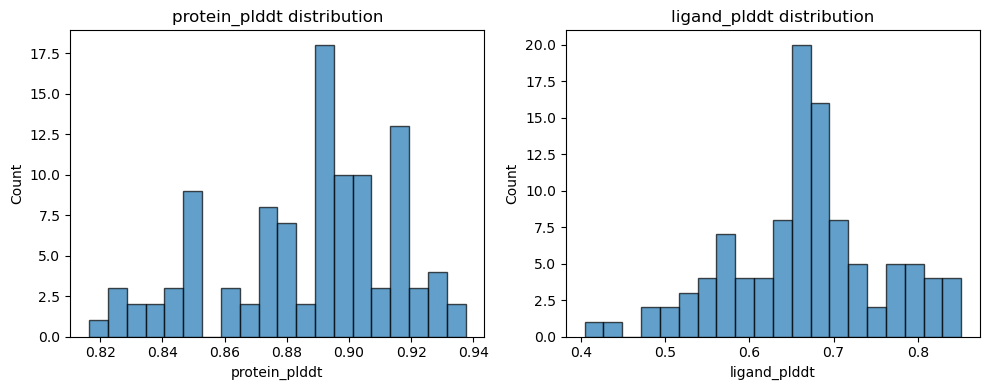

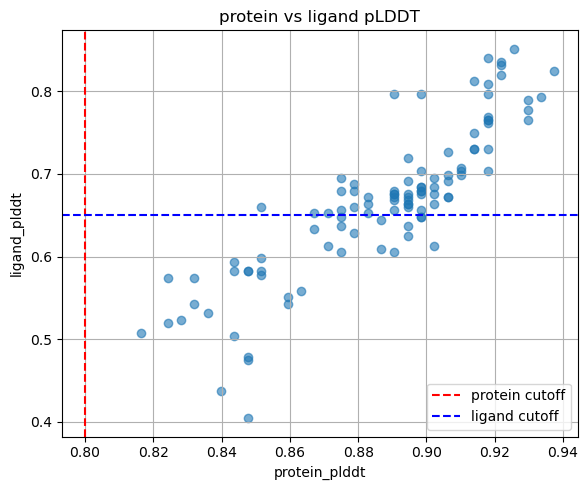

In [51]:
##Step 5: Screening protein_plddt against ligand_plddt in output plddt_summary file
# Load the pLDDT summary CSV
scores = pd.read_csv(output_csv)

# Define filter conditions
# Format: "column_name": [cutoff, operator]
filters = {
    "protein_plddt": [0.80, ">="],
    "ligand_plddt": [0.65, ">="]
}

# Comparison function mapping
comparisons = {
    ">=": "__ge__",
    "<=": "__le__",
    ">": "__gt__",
    "<": "__lt__",
    "=": "__eq__"
}

# Filtering function
def filter_scores(scores, filters):
    filtered_scores = scores.copy()
    for s in filters.keys():
        if filters[s] is not None and s in scores.columns:
            val = filters[s][0]
            sign = comparisons[filters[s][1]]
            filtered_scores = filtered_scores.loc[
                filtered_scores[s].__getattribute__(sign)(val)
            ]
            n_passed = len(scores.loc[scores[s].__getattribute__(sign)(val)])
            print(f"{s:<18} {filters[s][1]:<2} {val:>7.3f}: {len(filtered_scores)} "
                  f"items left. {n_passed} pass ({(n_passed / len(scores)) * 100:.0f}%).")
    return filtered_scores

# Apply filters
filtered_scores = filter_scores(scores, filters)

# Save filtered results
filtered_scores.to_csv("/rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_Protenix/result/plddt_filtered.csv", index=False)

# Plot histograms
plt.figure(figsize=(10, 4))
for i, k in enumerate(filters):
    plt.subplot(1, 2, i + 1)
    plt.hist(scores[k], bins=20, alpha=0.7, edgecolor='black')
    plt.title(f"{k} distribution")
    plt.xlabel(k)
    plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2D scatter plot: protein vs ligand pLDDT
plt.figure(figsize=(6, 5))
plt.scatter(scores["protein_plddt"], scores["ligand_plddt"], alpha=0.6)
plt.axvline(filters["protein_plddt"][0], color='red', linestyle='--', label="protein cutoff")
plt.axhline(filters["ligand_plddt"][0], color='blue', linestyle='--', label="ligand cutoff")
plt.xlabel("protein_plddt")
plt.ylabel("ligand_plddt")
plt.title("protein vs ligand pLDDT")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
#Step 5.5: Copy over to good directory
Converted_DIR = f"{WDIR}/8.1_Protenix/result/converted_pdbs"

good_dir = os.path.join(Converted_DIR, "good")

# Ensure good directory exists
os.makedirs(good_dir, exist_ok=True)

# Use previously defined `filtered_scores`
assert "file_name" in filtered_scores.columns, "file_name column missing in filtered_scores"

# Track copied files
copied = []

# Process each row from filtered JSONs
for _, row in filtered_scores.iterrows():
    json_file = row["file_name"]

    # Convert JSON name to expected PDB base name
    base = json_file.replace("_summary_confidence", "").replace(".json", "").lower()

    # Expected PDB file name
    pdb_file = f"{base}_predicted_by_protenix.pdb"
    pdb_path = os.path.join(Converted_DIR, pdb_file)

    # Copy if exists
    if os.path.exists(pdb_path):
        copy2(pdb_path, os.path.join(good_dir, pdb_file))
        copied.append(pdb_file)
    else:
        print(f"Warning: PDB not found for {json_file} -> {pdb_file}")

# Final summary
print(f"\n Copied {len(copied)} good PDB files to: {good_dir}")
if len(copied) == 0:
    print(" No valid PDBs were copied. Check your naming logic or paths.")


 Copied 69 good PDB files to: /rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_repeat/result/converted_pdbs/good


### Step 6: Screen by Angle Calculator/ Ligand RMSD (Per atom RMSD)

`
I probably should use rosetta pose1 and pose2 for the pdb file pair?
Yes I should. PyRosetta have a function called all_atom_rmsd() 
Diffusion environment can do the work as PyRosetta have been added already.
`

In [18]:
##Single_Calc
PDB_input_dir = "/rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_Protenix/result/converted_pdbs/good/"
sigma_angle_file = "/rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_Protenix/result/protenix_sigma.xlsx"

pdb_files = [os.path.join(PDB_input_dir, f) for f in os.listdir(PDB_input_dir) if f.endswith(".pdb")]
if not pdb_files:
    print(f"No PDB files found in {PDB_input_dir}")
    sys.exit(1)
if os.path.exists(sigma_angle_file):
    angles_df = pd.read_excel(sigma_angle_file)
else:
    angles_df = pd.DataFrame(columns=["File", "Chain_ID", "Residue_Number", "Angle1", "Angle2", "Angle3"])
def find_target_residues(structure):
    target_residues = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.get_resname() == "PCB":  # Adjust this ligand name
                    #print(f"Found target residue: {residue.get_resname()} at chain {chain.id}, residue {residue.id}")
                    target_residues.append((chain.id, residue))
    return target_residues
def get_atom_vector(residue, atom_name):
    if atom_name in residue:
        return residue[atom_name].get_vector()
    else:
        print(f"Warning: Missing atom {atom_name} in residue {residue.get_resname()}. Skipping this calculation.")
        return None
def calculate_torsion(structure, atoms):
    try:
        model = structure[0]

        def get_vector_for_atom(atom_info):
            chain = model[atom_info[0]] if atom_info[0] in model else None
            if not chain:
                print(f"Chain {atom_info[0]} not found.")
                return None
            for res_id, residue in chain.child_dict.items():
                if residue.id[1] == atom_info[1]: 
                    atom_vector = get_atom_vector(residue, atom_info[2])
                    if atom_vector is None:
                        print(f"Atom {atom_info[2]} not found in residue {res_id}")
                    return atom_vector
            print(f"Residue {atom_info[1]} not found in chain {atom_info[0]}")
            return None
        vec1 = get_vector_for_atom(atoms[0])
        vec2 = get_vector_for_atom(atoms[1])
        vec3 = get_vector_for_atom(atoms[2])
        vec4 = get_vector_for_atom(atoms[3])
        if None in [vec1, vec2, vec3, vec4]:
            print("Skipping torsion calculation due to missing atoms.")
            return None  
        torsion_angle = math.degrees(calc_dihedral(vec1, vec2, vec3, vec4))
        return round(torsion_angle, 3)
    except KeyError as e:
        print(f"Error calculating torsion angle: {e}")
        return None
for input_pdb in pdb_files:
    input_pdb_name = os.path.splitext(os.path.basename(input_pdb))[0]
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("Analysis", input_pdb)
    target_residues = find_target_residues(structure)
    for chain_id, residue in target_residues:
        res_num = residue.id[1]
        torsion_set1 = [(chain_id, res_num, "C24"), (chain_id, res_num, "C21"), (chain_id, res_num, "C12"), (chain_id, res_num, "N2")]
        torsion_set2 = [(chain_id, res_num, "C6"), (chain_id, res_num, "C7"), (chain_id, res_num, "C2"), (chain_id, res_num, "C1")]
        torsion_set3 = [(chain_id, res_num, "C3"), (chain_id, res_num, "C4"), (chain_id, res_num, "C15"), (chain_id, res_num, "C11")]
        angle1 = calculate_torsion(structure, torsion_set1)
        angle2 = calculate_torsion(structure, torsion_set2)
        angle3 = calculate_torsion(structure, torsion_set3)
        new_row = pd.DataFrame({
            "File": [input_pdb_name],
            "Chain_ID": [chain_id],
            "Residue_Number": [res_num],
            "Angle1": [angle1],
            "Angle2": [angle2],
            "Angle3": [angle3]
        })
        angles_df = pd.concat([angles_df, new_row], ignore_index=True)
angles_df.to_excel(sigma_angle_file, index=False)
print(f"Angles data saved to {sigma_angle_file}")

/var/tmp/pbs.477692.pbs-7/ipykernel_3054282/425250989.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  angles_df = pd.concat([angles_df, new_row], ignore_index=True)


Angles data saved to /rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_Protenix/result/protenix_sigma.xlsx


In [54]:
#Double_Calc
output_file = "/rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_Protenix/result/protenix_double.xlsx"

pdb_files = [os.path.join(PDB_input_dir, f) for f in os.listdir(PDB_input_dir) if f.endswith(".pdb")]
if not pdb_files:
    print(f"No PDB files found in {PDB_input_dir}")
    sys.exit(1)
if os.path.exists(output_file):
    angles_df = pd.read_excel(output_file)
else:
    angles_df = pd.DataFrame(columns=["File", "Chain_ID", "Residue_Number", "Angle1", "Angle2", "Angle3"])
parser = PDBParser(QUIET=True)
def find_target_residues(structure):
    target_residues = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.get_resname() == "PCB":  # Adjust this if necessary: UNK; UNL; BLA; CYC.
                    #print(f"Found target residue: {residue.get_resname()} at chain {chain.id}, residue {residue.id}")
                    target_residues.append((chain.id, residue))
    return target_residues
def get_atom_vector(residue, atom_name):
    if atom_name in residue:
        return residue[atom_name].get_vector()
    else:
        print(f"Warning: Missing atom {atom_name} in residue {residue.get_resname()}. Skipping this calculation.")
        return None
def calculate_torsion(structure, atoms):
    try:
        model = structure[0]

        def get_vector_for_atom(atom_info):
            """ Retrieves atom vector correctly for both standard residues and heteroatoms """
            chain = model[atom_info[0]] if atom_info[0] in model else None
            if not chain:
                print(f"Chain {atom_info[0]} not found.")
                return None
            for res_id, residue in chain.child_dict.items():
                if residue.id[1] == atom_info[1]:  # Match residue number
                    atom_vector = get_atom_vector(residue, atom_info[2])
                    if atom_vector is None:
                        print(f"Atom {atom_info[2]} not found in residue {res_id}")
                    return atom_vector
            print(f"Residue {atom_info[1]} not found in chain {atom_info[0]}")
            return None
        vec1 = get_vector_for_atom(atoms[0])
        vec2 = get_vector_for_atom(atoms[1])
        vec3 = get_vector_for_atom(atoms[2])
        vec4 = get_vector_for_atom(atoms[3])
        if None in [vec1, vec2, vec3, vec4]:
            print("Skipping torsion calculation due to missing atoms.")
            return None  
        torsion_angle = math.degrees(calc_dihedral(vec1, vec2, vec3, vec4))
        return round(torsion_angle, 3)
    except KeyError as e:
        print(f"Error calculating torsion angle: {e}")
        return None
for input_pdb in pdb_files:
    input_pdb_name = os.path.splitext(os.path.basename(input_pdb))[0]
    structure = parser.get_structure("Analysis", input_pdb)
    target_residues = find_target_residues(structure)
    for chain_id, residue in target_residues:
        res_num = residue.id[1]
        torsion_set1 = [(chain_id, res_num, "C25"), (chain_id, res_num, "C24"), (chain_id, res_num, "C21"), (chain_id, res_num, "C12")]
        torsion_set2 = [(chain_id, res_num, "C5"), (chain_id, res_num, "C6"), (chain_id, res_num, "C7"), (chain_id, res_num, "C2")]
        torsion_set3 = [(chain_id, res_num, "C13"), (chain_id, res_num, "C11"), (chain_id, res_num, "C15"), (chain_id, res_num, "C4")]
        angle1 = calculate_torsion(structure, torsion_set1)
        angle2 = calculate_torsion(structure, torsion_set2)
        angle3 = calculate_torsion(structure, torsion_set3)
        new_row = pd.DataFrame({
            "File": [input_pdb_name],
            "Chain_ID": [chain_id],
            "Residue_Number": [res_num],
            "Angle1": [angle1],
            "Angle2": [angle2],
            "Angle3": [angle3]
        })
        angles_df = pd.concat([angles_df, new_row], ignore_index=True)
angles_df.to_excel(output_file, index=False)
print(f"Angles data saved to {output_file}")

/var/tmp/pbs.475064.pbs-7/ipykernel_2725670/2915566392.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  angles_df = pd.concat([angles_df, new_row], ignore_index=True)


Angles data saved to /rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_repeat/result/protenix_double.xlsx


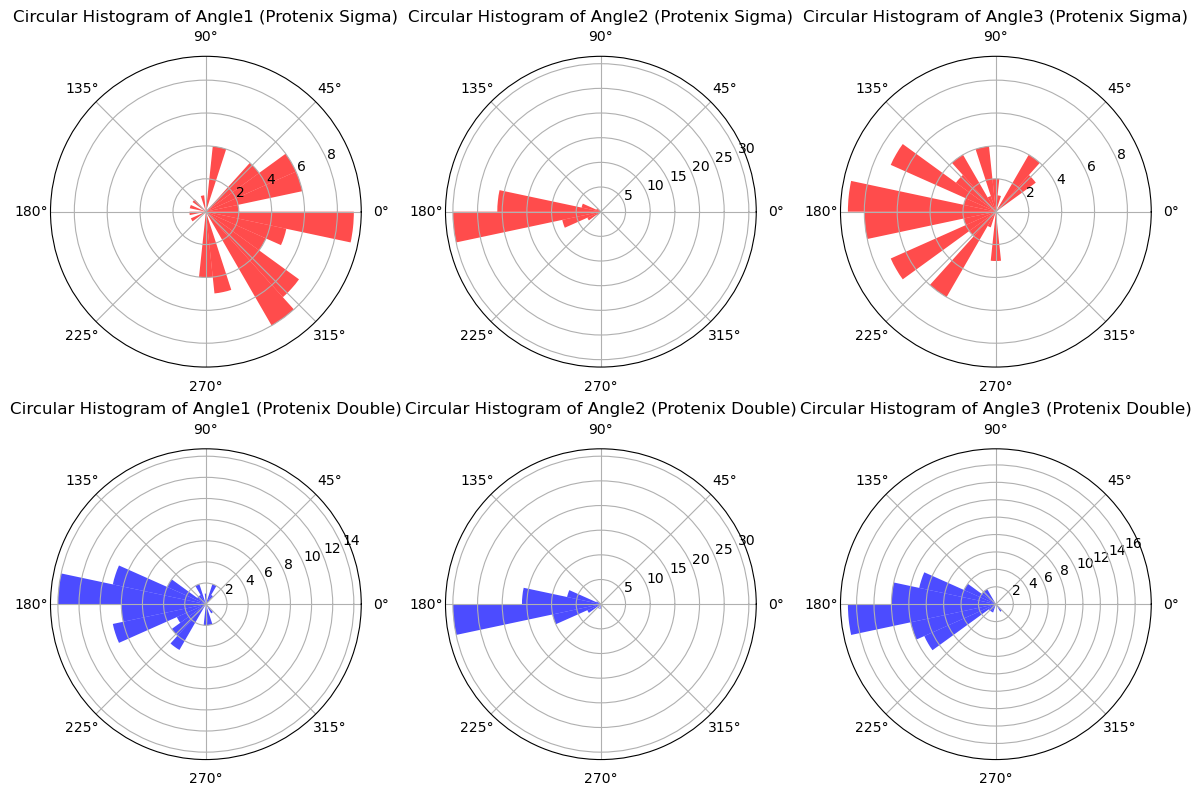

In [55]:
##Visulisation of Angle Calculators set output

Sigma_path = "/rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_Protenix/result/protenix_sigma.xlsx"
Pi_path = "/rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_Protenix/result/protenix_double.xlsx"


dfd1 = pd.read_excel(Sigma_path, sheet_name='Sheet1')
dfd2 = pd.read_excel(Pi_path, sheet_name='Sheet1')
angle_columns = ['Angle1', 'Angle2', 'Angle3']
dataset1_name = "Protenix Sigma"
dataset2_name = "Protenix Double"
fig, axes = plt.subplots(2, 3, subplot_kw={'projection': 'polar'}, figsize=(12, 8))
axes = axes.flatten()
num_bins = 30
width = (2 * np.pi) / num_bins
for i, angle in enumerate(angle_columns):
    angles_dfa = np.deg2rad(dfd1[angle])  # Dataset 1
    angles_dfb = np.deg2rad(dfd2[angle])  # Dataset 2
    hist_dfa, bins_dfa = np.histogram(angles_dfa, bins=num_bins, range=(-np.pi, np.pi))
    hist_dfb, bins_dfb = np.histogram(angles_dfb, bins=num_bins, range=(-np.pi, np.pi))
    theta_dfa = bins_dfa[:-1] + width / 2
    theta_dfb = bins_dfb[:-1] + width / 2
    bars_dfa = axes[i].bar(theta_dfa, hist_dfa, width=width, bottom=0, color='red', alpha=0.7)
    axes[i].set_title(f'Circular Histogram of {angle} ({dataset1_name})')
    bars_dfb = axes[i + len(angle_columns)].bar(theta_dfb, hist_dfb, width=width, bottom=0, color='blue', alpha=0.7)
    axes[i + len(angle_columns)].set_title(f'Circular Histogram of {angle} ({dataset2_name})')
plt.tight_layout()
plt.show()

In [56]:
%%bash
cd /rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_Protenix/result/converted_pdbs/good

for file in *.pdb; do
  sed -i 's/\bl01\b/PCB/g' "$file"
done
echo 'Job Done, Ligand Name switched'

Job Done, Ligand Name switched


In [57]:
# PyRosetta Ligand All(Heavy) Atom RMSD Calculator (LAAR)
AAR_DIR = f"{SCRIPT_DIR}/scripts/wenhan"

REF_DIR = f"{WDIR}/6.1_final_relax/good"
TARGET_DIR = f"{WDIR}/8.1_Protenix/result/converted_pdbs/good"
DUMP_DIR = f"{WDIR}/8.1_Protenix/result"


os.makedirs(f"{DUMP_DIR}/logs", exist_ok=True)
os.chdir(DUMP_DIR)

# Match reference and target PDBs
ref_and_model_pairs = []
for ref_pdb in glob.glob(f"{REF_DIR}/*.pdb"):
    ref_basename = os.path.basename(ref_pdb).replace(".pdb", "_").lower()
    for target_pdb in glob.glob(f"{TARGET_DIR}/*.pdb"):
        if ref_basename in os.path.basename(target_pdb).lower():
            ref_and_model_pairs.append((ref_pdb, target_pdb))

assert len(ref_and_model_pairs) > 0, "No reference-target pairs found"
print(f"Matched {len(ref_and_model_pairs)} PDB pairs.")
csv_output_path = os.path.abspath("rmsd_results.csv")
# Generate RMSD commands
commands_rmsd = []
cmds_filename = "commands_rmsd"
with open(cmds_filename, "w") as file:
    for ref_pdb, target_pdb in ref_and_model_pairs:
        cmd = (
            f"RMSD_CSV_PATH={csv_output_path} "
            f"{PYTHON['general']} {AAR_DIR}/all_atom_rmsd.py "
            f"--target_pdb {target_pdb} "
            f"--ref_pdb {ref_pdb} "
            f"--params {' '.join(params)}"
        )
        commands_rmsd.append(cmd)
        file.write(cmd + "\n")

print("Example RMSD command:")
print(commands_rmsd[-1])

submit_script = "submit_aar.sh"
utils.create_slurm_submit_script(filename=submit_script, name="8.1_all_atom_rmsd", mem="8g", 
                                 N_cores=1, time="24:00:00", email=EMAIL, array=len(commands_rmsd), group=10, 
                                 array_commandfile=cmds_filename)
print("PBS submission script created as 'submit_aar.sh'")
!realpath submit_aar.sh

Matched 69 PDB pairs.
Example RMSD command:
RMSD_CSV_PATH=/rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_repeat/result/rmsd_results.csv /rds/general/user/wh621/home/miniforge3/envs/diffusion/bin/python /rds/general/user/wh621/home/heme_binder_diffusion/scripts/wenhan/all_atom_rmsd.py --target_pdb /rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_repeat/result/converted_pdbs/good/1_dif_39_traj3_t0.3_0_21_model_4.0_r3_af2_pcb_mde_09_t0.1_0_1_model_4.0_r3_af2_pcb_rlx_0_seed_1640_sample_2_predicted_by_protenix.pdb --ref_pdb /rds/general/user/wh621/home/heme_binder_diffusion/output/6.1_repeat/good/1_dif_39_traj3_T0.3_0_21_model_4.0_r3_af2_PCB_mDE_09_T0.1_0_1_model_4.0_r3_af2_PCB_rlx_0.pdb --params /rds/general/user/wh621/home/heme_binder_diffusion/theozyme/PCB/PCB.params
PBS submission script created as 'submit_aar.sh'
/rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_repeat/result/submit_aar.sh


In [26]:
#Conformational Filter
sigma_path = "/rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_Protenix/result/protenix_sigma.xlsx"
pi_path = "/rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_Protenix/result/protenix_double.xlsx"


sigma_df = pd.read_excel(sigma_path)
pi_df = pd.read_excel(pi_path)

sigma_refs = {
    1: np.array([1, 8.706, 176.492, -31.206]),
    2: np.array([2, 137.589, -176.724, -32.492]),
    3: np.array([3, 150.066, 176.364, -30.272]),
    4: np.array([4, -173.476, 179.689, -0.709]),
    5: np.array([5, -152.446, -162.525, -31.397]),
    6: np.array([6, -151.465, 169.7, -34.026]),
    7: np.array([7, -26.522, -172.53, -27.661]),
    8: np.array([8, -11.887, -176.186, 176.207]),
    9: np.array([9, 140.877, -172.017, -107.923]),
    10: np.array([10, 7.905, -100.456, -94.172])
}
pi_refs = {
    1: np.array([1, -169.255, -167.959, 179.04]),
    2: np.array([2, -175.828, -171.463, 179.285]),
    3: np.array([3, -178.718, 177.119, 179.224]),
    4: np.array([4, -175.129, -176.573, -173.953]),
    5: np.array([5, -171.082, 175.069, -173.55]),
    6: np.array([6, -176.914, 174.458, 179.911]),
    7: np.array([7, 171.221, 175.004, -170.592]),
    8: np.array([8, 162.188, 175.374, -176.156]),
    9: np.array([9, 171.861, -177.86, -165.131]),
    10: np.array([10, -159.907, -175.776, -170.841])
}

sigma_df['file_index'] = sigma_df['File'].str.extract(r'^(\d+)').astype(int)
pi_df['file_index'] = pi_df['File'].str.extract(r'^(\d+)').astype(int)

def within_angle_tolerance(row, reference_dict):
    idx = row['file_index']
    if idx not in reference_dict:
        return False
    ref = reference_dict[idx][1:]
    angles = np.array([row['Angle1'], row['Angle2'], row['Angle3']])
    diff = np.abs((angles - ref + 180) % 360 - 180) #circular angle comparison
    return np.all(diff <= 45)

filtered_sigma = sigma_df[sigma_df.apply(lambda row: within_angle_tolerance(row, sigma_refs), axis=1)]
filtered_pi = pi_df[pi_df.apply(lambda row: within_angle_tolerance(row, pi_refs), axis=1)]

combined_filtered = pd.merge(filtered_sigma, filtered_pi, on='File', how='inner')
# combined_filtered.to_csv("/rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_Protenix/result/conformational_filtered.csv", index=False)
combined_filtered.to_csv("/rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_shadow/result/conformational_filtered.csv", index=False)
# combined_filtered.to_csv("/rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_repeat/result/conformational_filtered.csv", index=False)

print('done!')

done!


In [27]:
#Ligand Positional Filter **8.1 shadow been fucked
laar_result = "/rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_Protenix/result/rmsd_results.csv"

laar_df = pd.read_csv(laar_result, header=None)

# Use only first 4 columns and rename
laar_df = laar_df.iloc[:, :4]
laar_df.columns = ['File', 'Ref_File', 'Resno', 'RMSD']
laar_df['RMSD'] = pd.to_numeric(laar_df['RMSD'], errors='coerce')

# Filter: RMSD < 1.5
filtered_laar_df = laar_df[laar_df['RMSD'] < 2.2]

# Output path
output_dir = "/rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_Protenix/result"

output_file = os.path.join(output_dir, "positional_filtered.csv")

# Save with ; separator
filtered_laar_df.to_csv(output_file, index=False)

print("Filtered file saved to:", output_file)

Filtered file saved to: /rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_shadow/result/positional_filtered.csv


In [29]:
filtered_laar_df = filtered_laar_df.copy()
combined_filtered = combined_filtered.copy()
combined_filtered['File'] = np.where(
    combined_filtered['File'].str.endswith('.pdb'),
    combined_filtered['File'],
    combined_filtered['File'] + '.pdb'
)

filtered_laar_df['File'] = np.where(
    filtered_laar_df['File'].str.endswith('.pdb'),
    filtered_laar_df['File'],
    filtered_laar_df['File'] + '.pdb'
)

common_files = sorted(set(combined_filtered['File']) & set(filtered_laar_df['File']))

pd.DataFrame({'File': common_files}).to_csv(
    "/rds/general/user/wh621/home/heme_binder_diffusion/output/8.1_Protenix/result/triple_filtered.csv",
    index=False
)

print(f"triple_filtered.csv saved with {len(common_files)} entries.")
original_count = len(sigma_df)
conformational_count = len(combined_filtered)
positional_count = len(filtered_laar_df)
final_common_files = set(combined_filtered['File']) & set(filtered_laar_df['File'])
final_count = len(final_common_files)
conformational_pct = 100 * conformational_count / original_count
positional_pct = 100 * positional_count / original_count
final_pct = 100 * final_count / original_count

# Print report
print(f"Original entries:            {original_count}")
print(f"Conformational passed:       {conformational_count} ({conformational_pct:.2f}%)")
print(f"Positional passed:           {positional_count} ({positional_pct:.2f}%)")
print(f"Passed both (final):         {final_count} ({final_pct:.2f}%)")


## Copy to new directory
import re
# converted_dir = os.path.join(WDIR, "6.1_final_relax/good")
# final_dir = os.path.join(WDIR, "9_galiganddock/input")

converted_dir = os.path.join(WDIR, "6.1_shadow/good")
final_dir = os.path.join(WDIR, "9_shadow/input")

# converted_dir = os.path.join(WDIR, "6.1_repeat/good")
# final_dir = os.path.join(WDIR, "9_repeat/input")
os.makedirs(final_dir, exist_ok=True)

copied = set()

# Regex pattern to strip suffix
suffix_pattern = re.compile(r"_seed_\d+_sample_\d+_predicted_by_protenix\.pdb$", re.IGNORECASE)

# Create a dict of {lowercased_filename: original_filename} from source directory
available_files_dict = {
    fname.lower(): fname for fname in os.listdir(converted_dir)
    if fname.lower().endswith('.pdb')
}

for file_name in common_files:
    # Strip suffix and lowercase for matching
    base_name = suffix_pattern.sub(".pdb", file_name).lower()

    if base_name in available_files_dict and base_name not in copied:
        original_name = available_files_dict[base_name]
        src = os.path.join(converted_dir, original_name)
        dst = os.path.join(final_dir, original_name)
        copy2(src, dst)
        copied.add(base_name)
    elif base_name not in available_files_dict:
        print(f"Warning: Base file not found — {base_name}")

# Summary
print(f"\nCopied {len(copied)} PDB files to: {final_dir}")
if len(copied) == 0:
    print("No valid PDBs were copied. Try again.")

triple_filtered.csv saved with 3 entries.
Original entries:            1514
Conformational passed:       3 (0.20%)
Positional passed:           788 (52.05%)
Passed both (final):         3 (0.20%)

Copied 2 PDB files to: /rds/general/user/wh621/home/heme_binder_diffusion/output/9_shadow/input


### 9. Energy Filtering - GAligandDock

This method is selected to replicate original all-atom paper (https://www.science.org/doi/10.1126/science.adl2528). 

In [64]:
os.chdir(WDIR)
Score_GAligandDock = f"{WDIR}/9_galiganddock"

os.makedirs(Score_GAligandDock, exist_ok=True)
os.chdir(Score_GAligandDock)

holo_pdb_DIR = f"{WDIR}/9_galiganddock/input"

os.makedirs(Score_GAligandDock+"/logs", exist_ok=True)
NSTRUCT = 10
commands_GAligandDock = []
cmds_filename_des = "commands_GAligandDock"
with open(cmds_filename_des, "w") as file:
    for pdb in glob.glob(f"{holo_pdb_DIR}/*.pdb"):
        commands_GAligandDock.append(f"{PYTHON['general']} {SCRIPT_DIR}/scripts/wenhan/GAligandDock.py "
                             f"--pdb {pdb} --nstruct {NSTRUCT} "
                             f"--params {' '.join(params)} > logs/{os.path.basename(pdb).replace('.pdb', '.log')}\n") 
        file.write(commands_GAligandDock[-1])

print("Example GAligandDock command:")
print(commands_GAligandDock[-1])


### Running design jobs with Slurm.
submit_script = "submit_GAligandDock.sh"
utils.create_slurm_submit_script(filename=submit_script, name="GAligandDock", mem="32g", group=15, 
                                 N_cores=4, time="1:00", email=EMAIL, array=len(commands_GAligandDock),
                                 array_commandfile=cmds_filename_des)

Example GAligandDock command:
/rds/general/user/wh621/home/miniforge3/envs/diffusion/bin/python /rds/general/user/wh621/home/heme_binder_diffusion/scripts/wenhan/GAligandDock.py --pdb /rds/general/user/wh621/home/heme_binder_diffusion/output/9_repeat/input/1_dif_39_traj2_T0.3_0_64_model_4.0_r3_af2_PCB_mDE_11_T0.2_0_1_model_4.0_r3_af2_PCB_rlx_0.pdb --nstruct 10 --params /rds/general/user/wh621/home/heme_binder_diffusion/theozyme/PCB/PCB.params > logs/1_dif_39_traj2_T0.3_0_64_model_4.0_r3_af2_PCB_mDE_11_T0.2_0_1_model_4.0_r3_af2_PCB_rlx_0.log



GALigandDock Result cleaned, only total_score, score_per_res & pdb name been preserved in new file. easier to read


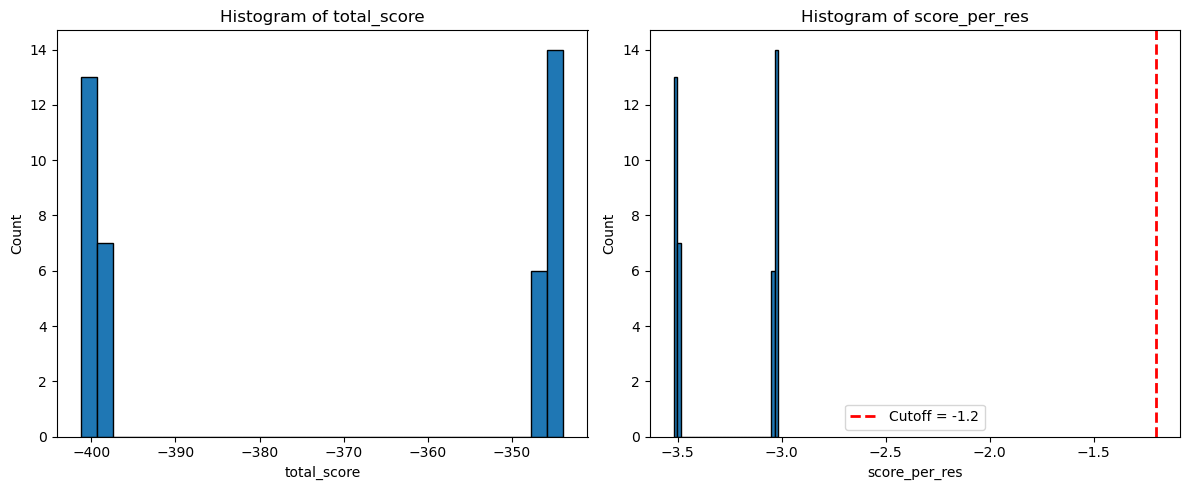

In [12]:
raw_csv = '/rds/general/user/wh621/home/heme_binder_diffusion/output/9_galiganddock/outputs/Scoring.csv'
cleaned_csv = '/rds/general/user/wh621/home/heme_binder_diffusion/output/9_galiganddock/outputs/Scoring_cleaned.csv'


def clean_csv_columns(input_path, output_path, keep_columns=4):
    with open(input_path, 'r', newline='') as infile, open(output_path, 'w', newline='') as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)

        for row in reader:
            writer.writerow(row[:keep_columns])
clean_csv_columns(raw_csv, cleaned_csv, keep_columns=4)
print('GALigandDock Result cleaned, only total_score, score_per_res & pdb name been preserved in new file. easier to read')

df = pd.read_csv(cleaned_csv)

# Create subplots: Left for total_score, Right for score_per_res
plt.figure(figsize=(12, 5))

# Left subplot - total_score
plt.subplot(1, 2, 1)
plt.hist(df['total_score'], bins=30, edgecolor='black')
plt.xlabel('total_score')
plt.ylabel('Count')
plt.title('Histogram of total_score')

# Right subplot - score_per_res with red dashed line at x=-1.8
plt.subplot(1, 2, 2)
plt.hist(df['score_per_res'], bins=30, edgecolor='black')
plt.axvline(x=-1.2, color='red', linestyle='--', linewidth=2, label='Cutoff = -1.2')
plt.xlabel('score_per_res')
plt.ylabel('Count')
plt.title('Histogram of score_per_res')
plt.legend()

# Display both plots
plt.tight_layout()
plt.show()

### 10 Remove non-align, get final result.

Torsion_calc, Double_calc, LAAR_Calc and Rosetta Energy Unit in `Score.csv` from GALigandDock.

In [13]:
##Single_Calc
os.makedirs("/rds/general/user/wh621/home/heme_binder_diffusion/output/10_good/Excels", exist_ok=True)
PDB_input_dir = "/rds/general/user/wh621/home/heme_binder_diffusion/output/9_galiganddock/outputs"
sigma_angle_file = "/rds/general/user/wh621/home/heme_binder_diffusion/output/10_good/Excels/final_sigma.xlsx"


pdb_files = [os.path.join(PDB_input_dir, f) for f in os.listdir(PDB_input_dir) if f.endswith(".pdb")]
if not pdb_files:
    print(f"No PDB files found in {PDB_input_dir}")
    sys.exit(1)
if os.path.exists(sigma_angle_file):
    angles_df = pd.read_excel(sigma_angle_file)
else:
    angles_df = pd.DataFrame(columns=["File", "Chain_ID", "Residue_Number", "Angle1", "Angle2", "Angle3"])
def find_target_residues(structure):
    target_residues = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.get_resname() == "PCB":  # Adjust this ligand name
                    #print(f"Found target residue: {residue.get_resname()} at chain {chain.id}, residue {residue.id}")
                    target_residues.append((chain.id, residue))
    return target_residues
def get_atom_vector(residue, atom_name):
    if atom_name in residue:
        return residue[atom_name].get_vector()
    else:
        print(f"Warning: Missing atom {atom_name} in residue {residue.get_resname()}. Skipping this calculation.")
        return None
def calculate_torsion(structure, atoms):
    try:
        model = structure[0]

        def get_vector_for_atom(atom_info):
            chain = model[atom_info[0]] if atom_info[0] in model else None
            if not chain:
                print(f"Chain {atom_info[0]} not found.")
                return None
            for res_id, residue in chain.child_dict.items():
                if residue.id[1] == atom_info[1]: 
                    atom_vector = get_atom_vector(residue, atom_info[2])
                    if atom_vector is None:
                        print(f"Atom {atom_info[2]} not found in residue {res_id}")
                    return atom_vector
            print(f"Residue {atom_info[1]} not found in chain {atom_info[0]}")
            return None
        vec1 = get_vector_for_atom(atoms[0])
        vec2 = get_vector_for_atom(atoms[1])
        vec3 = get_vector_for_atom(atoms[2])
        vec4 = get_vector_for_atom(atoms[3])
        if None in [vec1, vec2, vec3, vec4]:
            print("Skipping torsion calculation due to missing atoms.")
            return None  
        torsion_angle = math.degrees(calc_dihedral(vec1, vec2, vec3, vec4))
        return round(torsion_angle, 3)
    except KeyError as e:
        print(f"Error calculating torsion angle: {e}")
        return None
for input_pdb in pdb_files:
    input_pdb_name = os.path.splitext(os.path.basename(input_pdb))[0]
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("Analysis", input_pdb)
    target_residues = find_target_residues(structure)
    for chain_id, residue in target_residues:
        res_num = residue.id[1]
        torsion_set1 = [(chain_id, res_num, "C24"), (chain_id, res_num, "C21"), (chain_id, res_num, "C12"), (chain_id, res_num, "N2")]
        torsion_set2 = [(chain_id, res_num, "C6"), (chain_id, res_num, "C7"), (chain_id, res_num, "C2"), (chain_id, res_num, "C1")]
        torsion_set3 = [(chain_id, res_num, "C3"), (chain_id, res_num, "C4"), (chain_id, res_num, "C15"), (chain_id, res_num, "C11")]
        angle1 = calculate_torsion(structure, torsion_set1)
        angle2 = calculate_torsion(structure, torsion_set2)
        angle3 = calculate_torsion(structure, torsion_set3)
        new_row = pd.DataFrame({
            "File": [input_pdb_name],
            "Chain_ID": [chain_id],
            "Residue_Number": [res_num],
            "Angle1": [angle1],
            "Angle2": [angle2],
            "Angle3": [angle3]
        })
        angles_df = pd.concat([angles_df, new_row], ignore_index=True)
angles_df.to_excel(sigma_angle_file, index=False)
print(f"Angles data saved to {sigma_angle_file}")

/var/tmp/pbs.477692.pbs-7/ipykernel_3054282/1983928264.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  angles_df = pd.concat([angles_df, new_row], ignore_index=True)


Angles data saved to /rds/general/user/wh621/home/heme_binder_diffusion/output/10_repeat/Excels/final_sigma.xlsx


In [14]:
#Double_Calc
output_file = "/rds/general/user/wh621/home/heme_binder_diffusion/output/10_good/Excels/final_pi.xlsx"

pdb_files = [os.path.join(PDB_input_dir, f) for f in os.listdir(PDB_input_dir) if f.endswith(".pdb")]
if not pdb_files:
    print(f"No PDB files found in {PDB_input_dir}")
    sys.exit(1)
if os.path.exists(output_file):
    angles_df = pd.read_excel(output_file)
else:
    angles_df = pd.DataFrame(columns=["File", "Chain_ID", "Residue_Number", "Angle1", "Angle2", "Angle3"])
parser = PDBParser(QUIET=True)
def find_target_residues(structure):
    target_residues = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.get_resname() == "PCB":  # Adjust this if necessary: UNK; UNL; BLA; CYC.
                    #print(f"Found target residue: {residue.get_resname()} at chain {chain.id}, residue {residue.id}")
                    target_residues.append((chain.id, residue))
    return target_residues
def get_atom_vector(residue, atom_name):
    if atom_name in residue:
        return residue[atom_name].get_vector()
    else:
        print(f"Warning: Missing atom {atom_name} in residue {residue.get_resname()}. Skipping this calculation.")
        return None
def calculate_torsion(structure, atoms):
    try:
        model = structure[0]

        def get_vector_for_atom(atom_info):
            """ Retrieves atom vector correctly for both standard residues and heteroatoms """
            chain = model[atom_info[0]] if atom_info[0] in model else None
            if not chain:
                print(f"Chain {atom_info[0]} not found.")
                return None
            for res_id, residue in chain.child_dict.items():
                if residue.id[1] == atom_info[1]:  # Match residue number
                    atom_vector = get_atom_vector(residue, atom_info[2])
                    if atom_vector is None:
                        print(f"Atom {atom_info[2]} not found in residue {res_id}")
                    return atom_vector
            print(f"Residue {atom_info[1]} not found in chain {atom_info[0]}")
            return None
        vec1 = get_vector_for_atom(atoms[0])
        vec2 = get_vector_for_atom(atoms[1])
        vec3 = get_vector_for_atom(atoms[2])
        vec4 = get_vector_for_atom(atoms[3])
        if None in [vec1, vec2, vec3, vec4]:
            print("Skipping torsion calculation due to missing atoms.")
            return None  
        torsion_angle = math.degrees(calc_dihedral(vec1, vec2, vec3, vec4))
        return round(torsion_angle, 3)
    except KeyError as e:
        print(f"Error calculating torsion angle: {e}")
        return None
for input_pdb in pdb_files:
    input_pdb_name = os.path.splitext(os.path.basename(input_pdb))[0]
    structure = parser.get_structure("Analysis", input_pdb)
    target_residues = find_target_residues(structure)
    for chain_id, residue in target_residues:
        res_num = residue.id[1]
        torsion_set1 = [(chain_id, res_num, "C25"), (chain_id, res_num, "C24"), (chain_id, res_num, "C21"), (chain_id, res_num, "C12")]
        torsion_set2 = [(chain_id, res_num, "C5"), (chain_id, res_num, "C6"), (chain_id, res_num, "C7"), (chain_id, res_num, "C2")]
        torsion_set3 = [(chain_id, res_num, "C13"), (chain_id, res_num, "C11"), (chain_id, res_num, "C15"), (chain_id, res_num, "C4")]
        angle1 = calculate_torsion(structure, torsion_set1)
        angle2 = calculate_torsion(structure, torsion_set2)
        angle3 = calculate_torsion(structure, torsion_set3)
        new_row = pd.DataFrame({
            "File": [input_pdb_name],
            "Chain_ID": [chain_id],
            "Residue_Number": [res_num],
            "Angle1": [angle1],
            "Angle2": [angle2],
            "Angle3": [angle3]
        })
        angles_df = pd.concat([angles_df, new_row], ignore_index=True)
angles_df.to_excel(output_file, index=False)
print(f"Angles data saved to {output_file}")

/var/tmp/pbs.477692.pbs-7/ipykernel_3054282/2920765003.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  angles_df = pd.concat([angles_df, new_row], ignore_index=True)


Angles data saved to /rds/general/user/wh621/home/heme_binder_diffusion/output/10_repeat/Excels/final_pi.xlsx


In [15]:
REF_DIR = f"{WDIR}/6.1_final_relax/good"
TARGET_DIR = f"{WDIR}/9_galiganddock/outputs"
AAR_DIR = f"{SCRIPT_DIR}/scripts/wenhan"
DUMP_DIR = f"{WDIR}/10_good/Excels/"


os.makedirs(f"{DUMP_DIR}/logs", exist_ok=True)
os.chdir(DUMP_DIR)

# Match reference and target PDBs
ref_and_model_pairs = []
for ref_pdb in glob.glob(f"{REF_DIR}/*.pdb"):
    ref_basename = os.path.basename(ref_pdb).replace(".pdb", "_").lower()
    for target_pdb in glob.glob(f"{TARGET_DIR}/*.pdb"):
        if ref_basename in os.path.basename(target_pdb).lower():
            ref_and_model_pairs.append((ref_pdb, target_pdb))

assert len(ref_and_model_pairs) > 0, "No reference-target pairs found"
print(f"Matched {len(ref_and_model_pairs)} PDB pairs.")
csv_output_path = os.path.abspath("rmsd_results.csv")
# Generate RMSD commands
commands_rmsd = []
cmds_filename = "commands_rmsd"
with open(cmds_filename, "w") as file:
    for ref_pdb, target_pdb in ref_and_model_pairs:
        cmd = (
            f"RMSD_CSV_PATH={csv_output_path} "
            f"{PYTHON['general']} {AAR_DIR}/all_atom_rmsd.py "
            f"--target_pdb {target_pdb} "
            f"--ref_pdb {ref_pdb} "
            f"--params {' '.join(params)}"
        )
        commands_rmsd.append(cmd)
        file.write(cmd + "\n")

print("Example RMSD command:")
print(commands_rmsd[-1])

submit_script = "submit_aar.sh"
utils.create_slurm_submit_script(filename=submit_script, name="8.1_all_atom_rmsd", mem="8g", 
                                 N_cores=1, time="24:00:00", email=EMAIL, array=len(commands_rmsd), group=10, 
                                 array_commandfile=cmds_filename)
print("PBS/SLURM submission script created as 'submit_rmsd.sh'")

Matched 20 PDB pairs.
Example RMSD command:
RMSD_CSV_PATH=/rds/general/user/wh621/home/heme_binder_diffusion/output/10_repeat/Excels/rmsd_results.csv /rds/general/user/wh621/home/miniforge3/envs/diffusion/bin/python /rds/general/user/wh621/home/heme_binder_diffusion/scripts/wenhan/all_atom_rmsd.py --target_pdb /rds/general/user/wh621/home/heme_binder_diffusion/output/9_repeat/outputs/1_dif_39_traj2_T0.3_0_64_model_4.0_r3_af2_PCB_mDE_11_T0.2_0_1_model_4.0_r3_af2_PCB_rlx_0_9.pdb --ref_pdb /rds/general/user/wh621/home/heme_binder_diffusion/output/6.1_repeat/good/1_dif_39_traj2_T0.3_0_64_model_4.0_r3_af2_PCB_mDE_11_T0.2_0_1_model_4.0_r3_af2_PCB_rlx_0.pdb --params /rds/general/user/wh621/home/heme_binder_diffusion/theozyme/PCB/PCB.params
PBS/SLURM submission script created as 'submit_rmsd.sh'


In [33]:
#Final Filter 
sigma_path = "/rds/general/user/wh621/home/heme_binder_diffusion/output/10_good/Excels/final_sigma.xlsx"
pi_path = "/rds/general/user/wh621/home/heme_binder_diffusion/output/10_good/Excels/final_pi.xlsx"
rmsd_path = "/rds/general/user/wh621/home/heme_binder_diffusion/output/10_good/Excels/rmsd_results.csv"
score_path = "/rds/general/user/wh621/home/heme_binder_diffusion/output/9_galiganddock/outputs/Scoring_cleaned.csv"
output_path = "/rds/general/user/wh621/home/heme_binder_diffusion/output/10_good/Excels/final_quad_filtered.csv"

sigma_df = pd.read_excel(sigma_path)
pi_df = pd.read_excel(pi_path)
rmsd_df = pd.read_csv(rmsd_path, header=None)
score_df = pd.read_csv(score_path, sep=',')
sigma_df['file_index'] = sigma_df['File'].str.extract(r'^(\d+)').astype(int)
pi_df['file_index'] = pi_df['File'].str.extract(r'^(\d+)').astype(int)
sigma_refs = {
    1: np.array([1, 8.706, 176.492, -31.206]),
    2: np.array([2, 137.589, -176.724, -32.492]),
    3: np.array([3, 150.066, 176.364, -30.272]),
    4: np.array([4, -173.476, 179.689, -0.709]),
    5: np.array([5, -152.446, -162.525, -31.397]),
    6: np.array([6, -151.465, 169.7, -34.026]),
    7: np.array([7, -26.522, -172.53, -27.661]),
    8: np.array([8, -11.887, -176.186, 176.207]),
    9: np.array([9, 140.877, -172.017, -107.923]),
    10: np.array([10, 7.905, -100.456, -94.172])
}
pi_refs = {
    1: np.array([1, -169.255, -167.959, 179.04]),
    2: np.array([2, -175.828, -171.463, 179.285]),
    3: np.array([3, -178.718, 177.119, 179.224]),
    4: np.array([4, -175.129, -176.573, -173.953]),
    5: np.array([5, -171.082, 175.069, -173.55]),
    6: np.array([6, -176.914, 174.458, 179.911]),
    7: np.array([7, 171.221, 175.004, -170.592]),
    8: np.array([8, 162.188, 175.374, -176.156]),
    9: np.array([9, 171.861, -177.86, -165.131]),
    10: np.array([10, -159.907, -175.776, -170.841])
}

def within_angle_tolerance(row, reference_dict):
    idx = row['file_index']
    if idx not in reference_dict:
        return False
    ref = reference_dict[idx][1:]
    angles = np.array([row['Angle1'], row['Angle2'], row['Angle3']])
    diff = np.abs((angles - ref + 180) % 360 - 180)
    return np.all(diff <= 60) # Change parameter if needed

filtered_sigma = sigma_df[sigma_df.apply(lambda row: within_angle_tolerance(row, sigma_refs), axis=1)]
filtered_pi = pi_df[pi_df.apply(lambda row: within_angle_tolerance(row, pi_refs), axis=1)]

# Merge sigma and pi conformational match
combined_filtered = pd.merge(filtered_sigma, filtered_pi, on="File", how="inner")

#RMSD filter
rmsd_df = rmsd_df.iloc[:, :4]
rmsd_df.columns = ['File', 'Ref_File', 'Resno', 'RMSD']
rmsd_df['RMSD'] = pd.to_numeric(rmsd_df['RMSD'], errors='coerce')
filtered_rmsd = rmsd_df[rmsd_df['RMSD'] < 1.8] # Change parameter if needed

#REU Scoring filter
score_df['output_name'] = score_df['output_name'].str.strip()
score_df['File'] = score_df['output_name'].str.replace('.pdb', '', regex=False)
filtered_score = score_df[score_df['score_per_res'] < -1.8] # Change parameter if needed

#Normalize file names and merge all
combined_filtered['File'] = combined_filtered['File'].astype(str)
# filtered_rmsd['File'] = filtered_rmsd['File'].str.replace('.pdb', '', regex=False)
filtered_rmsd.loc[:, 'File'] = filtered_rmsd['File'].str.replace('.pdb', '', regex=False)
filtered_score['File'] = filtered_score['File'].astype(str)

# Final intersection
common_files = set(combined_filtered['File']) & set(filtered_rmsd['File']) & set(filtered_score['File'])

# Save results
pd.DataFrame({'File': sorted(common_files)}).to_csv(output_path, index=False)
print(len(combined_filtered), " passed Torsion Filter")
print(len(filtered_rmsd), " passed LAAR Filter" )
print(len(filtered_score)," passed REU Filter")
print(f" final_quad_filtered.csv saved with {len(common_files)} entries at:\n{output_path}")

5  passed Torsion Filter
43  passed LAAR Filter
150  passed REU Filter
 final_quad_filtered.csv saved with 4 entries at:
/rds/general/user/wh621/home/heme_binder_diffusion/output/10_shadow/Excels/final_quad_filtered.csv


In [34]:
input_dir = os.path.join(WDIR, "6.1_final_relax/good")
final_dir = os.path.join(WDIR, "10_good/result")

os.makedirs(final_dir, exist_ok=True)

# Create a set of available PDB filenames in the source directory
available_files = set(
    fname for fname in os.listdir(input_dir)
    if fname.endswith('.pdb')
)

# Copy matching files from input_dir to final_dir
copied = set()

for file_name in common_files:
    simplified_name = re.sub(r'_\d+$', '', file_name)
    pdb_name = f"{simplified_name}.pdb"

    if pdb_name in available_files and pdb_name not in copied:
        src = os.path.join(input_dir, pdb_name)
        dst = os.path.join(final_dir, pdb_name)
        copy2(src, dst)
        copied.add(pdb_name)
    else:
        print(f"Warning: File not found — {file_name} → tried {pdb_name}")

# Summary report
print(f"\nCopied {len(copied)} PDB files to: {final_dir}")
if len(copied) == 0:
    print("No valid PDBs were copied. Check naming or input directory.")
#Report section
original_count = len(sigma_df)
conformational_count = len(combined_filtered)
positional_count = len(filtered_rmsd)
scoring_count = len(filtered_score)
final_common_files = set(combined_filtered['File']) & set(filtered_rmsd['File']) & set(filtered_score['File'])
final_count = len(final_common_files)
conformational_pct = 100 * conformational_count / original_count
positional_pct = 100 * positional_count / original_count
scoring_pct = 100 * scoring_count / original_count
final_pct = 100 * final_count / original_count

print("\n===  Filtering Summary ===")
print(f"Original entries:            {original_count}")
print(f"Conformational passed:       {conformational_count} ({conformational_pct:.2f}%)")
print(f"Positional (RMSD) passed:    {positional_count} ({positional_pct:.2f}%)")
print(f"Scoring passed:              {scoring_count} ({scoring_pct:.2f}%)")
print(f"Passed all filters (final):  {final_count} ({final_pct:.2f}%)")

print(f"\n Copied {len(copied)} PDB files to: {final_dir}")
if len(copied) == 0:
    print(" No valid PDBs were copied.")
else:
    print('For those who last till this step, they could be considered as real good designs.')


Copied 2 PDB files to: /rds/general/user/wh621/home/heme_binder_diffusion/output/10_shadow/result

===  Filtering Summary ===
Original entries:            90
Conformational passed:       5 (5.56%)
Positional (RMSD) passed:    43 (47.78%)
Scoring passed:              150 (166.67%)
Passed all filters (final):  4 (4.44%)

 Copied 2 PDB files to: /rds/general/user/wh621/home/heme_binder_diffusion/output/10_shadow/result
For those who last till this step, they could be considered as real good designs.


# <i>The following part of the pipeline branches off after the Design step (8-10)

## 8.2: Validation of Final Designs from Section 6.1 Using Boltz-2 (https://github.com/jwohlwend/boltz)
Recent benchmarking suggests that Protenix is not the 'best' open-source implementation of AlphaFold3. It is therefore desirable to switch to a more up-to-date and reliable model. I have chosen to use Boltz-2 for the following reasons:

1. Speed: Each structure prediction takes approximately 20 seconds.

2. Reliability: Boltz-1 has shown benchmarking results closest to the original AlphaFold3, and Boltz-2 is expected to further improve upon this. It is currently regarded as one of the most faithful open-source reproductions available.

3. Energy Module: Boltz-2 includes a straightforward module for estimating energy and ligand binding affinity. It provides results in kJ/mol rather than in arbitrary Rosetta Energy Units for GALigandDock, making interpretation more intuitive and compatible with standard biochemical conventions.

As a result, only two models will be compared (in design + Boltz-2) instead of three (in_design + Protenix + GALigandDock), overall pipeline is simplified but the reliability of the validation process is expected to improve.

In [ ]:
INPUT_DIR = f"{WDIR}/6.1_final_relax/good/"
YAML_OUTPUT_DIR = f"{WDIR}/8.2_Boltz2/yaml_inputs/"
os.makedirs(YAML_OUTPUT_DIR, exist_ok=True)

Ligand_SMILES = 'C/C=C1C(=C/c2[nH]c(/C=c3\\[nH]/c(=C\\C4=NC(=O)C(CC)=C4C)c(C)c3CCC(=O)O)c(CCC(=O)O)c2C)/NC(=O)[C@@H]/1C'

#PDB SEQUENCE EXTRACTION
parser = PDBParser(QUIET=True)
ppb = PPBuilder()

for pdb_file in glob.glob(os.path.join(INPUT_DIR, "*.pdb")):
    structure = parser.get_structure("struct", pdb_file)
    model = next(structure.get_models())

    if "A" not in model:
        print(f"Chain A not found in {pdb_file}. Skipping...")
        continue

    chain = model["A"]
    seq = ""
    for pp in ppb.build_peptides(chain):
        seq += str(pp.get_sequence())

    base_name = os.path.basename(pdb_file).replace(".pdb", "")

    # YAML DATA CONSTRUCTION
    yaml_dict = {
        "version": 1,
        "sequences": [
            {
                "protein": {
                    "id": "A",
                    "sequence": seq
                }
            },
            {
                "ligand": {
                    "id": "B",
                    "smiles": Ligand_SMILES
                }
            }
        ],
        "properties": [
            {
                "affinity": {
                    "binder": "B"
                }
            }
        ]
    }

    yaml_file = os.path.join(YAML_OUTPUT_DIR, f"{base_name}.yaml")
    with open(yaml_file, "w") as f:
        yaml.dump(yaml_dict, f, sort_keys=False)

    print(f"Generated Boltz-2 YAML for {base_name} -> {yaml_file}")


## 
## --------------------------------------------------------------------------------------------------------------------

# <i>The following part of the pipeline branches off after the first AlphaFold2 step (2)

## 3.2: Performing binding site design with Rosetta FastDesign
<a id='Rosetta_design'></a>

In [ ]:
### Setting up design directory and commands
os.chdir(WDIR)
DESIGN_DIR_ROSETTA = f"{WDIR}/3.2_design_pocket_Rosetta"
os.makedirs(DESIGN_DIR_ROSETTA, exist_ok=True)
os.chdir(DESIGN_DIR_ROSETTA)
AF2_DIR = f"{WDIR}/2_af2"

os.makedirs(DESIGN_DIR_ROSETTA+"/logs", exist_ok=True)

### Performing 5 design iterations on each input structure
NSTRUCT = 5
cstfile = f"{SCRIPT_DIR}/theozyme/HBA/HBA_CYS_UPO.cst"

commands_design = []
cmds_filename_des = "commands_design"
with open(cmds_filename_des, "w") as file:
    for pdb in glob.glob(f"{AF2_DIR}/good/with_heme/*.pdb"):
        commands_design.append(f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/heme_pocket_FastDesign.py "
                             f"--pdb {pdb} --norelax --nstruct {NSTRUCT} "
                             f"--params {' '.join(params)} --cstfile {cstfile} > logs/{os.path.basename(pdb).replace('.pdb', '.log')}\n")
        file.write(commands_design[-1])

print("Example design command:")
print(commands_design[-1])


### Running design jobs with Slurm.
submit_script = "submit_design.sh"
utils.create_slurm_submit_script(filename=submit_script, name="3.2_design_pocket_Rosetta", mem="4g", 
                                 N_cores=1, time="3:00:00", email=EMAIL, array=len(commands_design),
                                 array_commandfile=cmds_filename_des)

if not os.path.exists(DESIGN_DIR_ROSETTA+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()

In [ ]:
## If you're done with design and happy with the outputs then mark it as done
DESIGN_DIR_ROSETTA = f"{WDIR}/3.2_design_pocket_Rosetta"
os.chdir(DESIGN_DIR_ROSETTA)

if not os.path.exists(DESIGN_DIR_ROSETTA+"/.done"):
    with open(f"{DESIGN_DIR_ROSETTA}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

In [ ]:
## Analyzing Rosetta designs
scores = pd.read_csv("scorefile.txt", sep="\s+", header=0)

filters = {'all_cst': [1.0, '<='],
 'nlr_SR1_rms': [0.8, '<='],
 'nlr_totrms': [1.0, '<='],
 'L_SASA': [0.2, '<='],
 'COO_hbond': [1.0, '='],
 'heme_angle_wrst': [80.0, '>='],
 'score_per_res': [0.0, '<='],
 'corrected_ddg': [-50.0, '<='],
 'cms_per_atom': [4.8, '>=']}

filtered_scores = utils.filter_scores(scores, filters)

## Plotting AF2 scores
plt.figure(figsize=(12, 9))
for i,k in enumerate(filters):
    plt.subplot(3, 3, i+1)
    plt.hist(scores[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()

### Copying good designs over to a new directory
if len(filtered_scores) > 0:
    os.makedirs(f"{DESIGN_DIR_ROSETTA}/good", exist_ok=True)
    for idx, row in filtered_scores.iterrows():
        copy2(row["description"]+".pdb", "good/"+row["description"]+".pdb")
else:
    print("No good designs created, bummer...")

## 4.2 Performing ligandMPNN redesign on the 2nd layer residues

Resampling residues that are not in the pocket, but also not very far from the pocket

In [ ]:
if len(glob.glob(DESIGN_DIR_ROSETTA+'/good/*.pdb')) == 0:
    sys.exit("No designs to run 2nd MPNN on.")

os.chdir(WDIR)
DESIGN_DIR_2nd_mpnn = f"{WDIR}/4.2_2nd_mpnn"
os.makedirs(DESIGN_DIR_2nd_mpnn, exist_ok=True)
os.chdir(DESIGN_DIR_2nd_mpnn)

### Making a JSON file specifiying designable positions for each structure.
### Will also make non-pocket ALA positions as designable.
### This is to fix any surface ALA-patches that previous MPNN may have introduced.

make_json_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/setup_ligand_mpnn_2nd_layer.py "\
                f"--params {' '.join(params)} --ligand {LIGAND} --output_path parsed_pdbs_lig.jsonl "\
                 "--output_path masked_pos.jsonl --dist_bb 6.0 --dist_sc 5.0 "\
                f"--pdb {' '.join(glob.glob(DESIGN_DIR_ROSETTA+'/good/*.pdb'))}"

p = subprocess.Popen(make_json_cmd, shell=True)
(output, err) = p.communicate()


### Setting up ligandMPNN run commands
## We're doing design with 2 temperatures (more conservative than before), and 5 sequences each.

MPNN_temperatures = [0.1, 0.2]
MPNN_outputs_per_temperature = 5
MPNN_omit_AAs = "CM"

commands_mpnn = []
cmds_filename_mpnn = "commands_mpnn"
with open(cmds_filename_mpnn, "w") as file:
    for T in MPNN_temperatures:
        for f in glob.glob(DESIGN_DIR_ROSETTA+'/good/*.pdb'):
            commands_mpnn.append(f"{PYTHON['proteinMPNN']} {proteinMPNN_script} "
                                 f"--model_type ligand_mpnn --ligand_mpnn_use_atom_context 1 "
                                 "--fixed_residues_multi masked_pos.jsonl --out_folder ./ "
                                 f"--number_of_batches {MPNN_outputs_per_temperature} --temperature {T} "
                                 f"--omit_AA {MPNN_omit_AAs} --pdb_path {f} "
                                 f"--checkpoint_protein_mpnn {SCRIPT_DIR}/lib/LigandMPNN/model_params/ligandmpnn_v_32_010_25.pt\n")
            file.write(commands_mpnn[-1])

print("Example MPNN command:")
print(commands_mpnn[-1])


### Running ligandMPNN with Slurm.
### Grouping jobs with 10 commands per one array job.
submit_script = "submit_mpnn.sh"
utils.create_slurm_submit_script(filename=submit_script, name="4.2_2nd_mpnn", mem="8g", 
                                 N_cores=1, time="0:15:00", email=EMAIL, array=len(commands_mpnn),
                                 array_commandfile=cmds_filename_mpnn, group=10)

if not os.path.exists(DESIGN_DIR_2nd_mpnn+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()


In [ ]:
## If you're done with design and happy with the outputs then mark it as done
DESIGN_DIR_2nd_mpnn = f"{WDIR}/4.2_2nd_mpnn"
os.chdir(DESIGN_DIR_2nd_mpnn)

if not os.path.exists(DESIGN_DIR_2nd_mpnn+"/.done"):
    with open(f"{DESIGN_DIR_2nd_mpnn}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

## 5.2 AlphaFold2 predictions on the 2nd MPNN run

In [ ]:
os.chdir(WDIR)
DESIGN_DIR_2nd_mpnn = f"{WDIR}/4.2_2nd_mpnn"
assert os.path.exists(DESIGN_DIR_2nd_mpnn+"/.done"), "2nd MPNN has not been performed!"

AF2_DIR = f"{WDIR}/5.2_2nd_af2"
os.makedirs(AF2_DIR, exist_ok=True)
os.chdir(AF2_DIR)
DESIGN_DIR_2nd_mpnn = f"{WDIR}/4.2_2nd_mpnn"

### First collecting MPNN outputs and creating FASTA files for AF2 input
mpnn_fasta = utils.parse_fasta_files(glob.glob(f"{DESIGN_DIR_2nd_mpnn}/seqs/*.fa"))
# Giving sequences unique names based on input PDB name, temperature, and sequence identifier
_mpnn_fasta = {}
for k, seq in mpnn_fasta.items():
    if "model_path" in k:
        _mpnn_fasta[k.split(",")[0]+"_native"] = seq.strip()
    else:
        _mpnn_fasta[k.split(",")[0]+"_"+k.split(",")[2].replace(" T=", "T")+"_0_"+k.split(",")[1].replace(" id=", "")] = seq.strip()
mpnn_fasta = {k:v for k,v in _mpnn_fasta.items()}

print(f"A total on {len(mpnn_fasta)} sequences will be predicted.")

## Splitting the MPNN sequences based on length
## and grouping them in smaller batches for each AF2 job
## Use group size of >40 when running on GPU. Also depends on how many sequences and resources you have.

SEQUENCES_PER_AF2_JOB = 5  # CPU
if USE_GPU_for_AF2 is True:
    SEQUENCES_PER_AF2_JOB = 100  # GPUSEQUENCES_PER_AF2_JOBSEQUENCES_PER_AF2_JOBSEQUENCES_PER_AF2_JOB
mpnn_fasta_split = utils.split_fasta_based_on_length(mpnn_fasta, SEQUENCES_PER_AF2_JOB, write_files=True)


In [ ]:
## Setting up AlphaFold2 run

AF2_recycles = 3
AF2_models = "4"  # add other models to this string if needed

commands_af2 = []
cmds_filename_af2 = "commands_af2"
with open(cmds_filename_af2, "w") as file:
    for ff in glob.glob("*.fasta"):
        commands_af2.append(f"{PYTHON['af2']} {AF2_script} "
                             f"--af-nrecycles {AF2_recycles} --af-models {AF2_models} "
                             f"--fasta {ff} --scorefile {ff.replace('.fasta', '.csv')}\n")
        file.write(commands_af2[-1])

print("Example AF2 command:")
print(commands_af2[-1])


### Running AF2 with Slurm.

submit_script = "submit_af2.sh"

if USE_GPU_for_AF2 is True:
    utils.create_slurm_submit_script(filename=submit_script, name="5.2_2nd_af2", mem="6g", 
                                     N_cores=2, gpu=True, gres="gpu:rtx2080:1", time="00:12:00", email=EMAIL, array=len(commands_af2),
                                     array_commandfile=cmds_filename_af2)
else:
    utils.create_slurm_submit_script(filename=submit_script, name="5.2_2nd_af2", mem="6g", 
                                     N_cores=4, time="01:00:00", email=EMAIL, array=len(commands_af2),
                                     array_commandfile=cmds_filename_af2)

if not os.path.exists(AF2_DIR+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()

In [ ]:
## If you're done with AF2 and happy with the outputs then mark it as done
AF2_DIR = f"{WDIR}/5.2_2nd_af2"
os.chdir(AF2_DIR)

if not os.path.exists(AF2_DIR+"/.done"):
    with open(f"{AF2_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

### Analyzing AlphaFold2 predictions

In [ ]:
# Combining all CSV scorefiles into one
DESIGN_DIR_ROSETTA = f"{WDIR}/3.2_design_pocket_Rosetta"

os.system("head -n 1 $(ls *aa*.csv | shuf -n 1) > scores.csv ; for f in *aa*.csv ; do tail -n +2 ${f} >> scores.csv ; done")
assert os.path.exists("scores.csv"), "Could not combine scorefiles"

### Calculating the RMSDs of AF2 predictions relative to the diffusion outputs
### Catalytic residue sidechain RMSDs are calculated in the reference PDB has REMARK 666 line present

analysis_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/utils/analyze_af2.py --scorefile scores.csv "\
               f"--ref_path {DESIGN_DIR_ROSETTA}/good/ --mpnn --params {' '.join(params)}"

p = subprocess.Popen(analysis_cmd, shell=True)
(output, err) = p.communicate()


In [ ]:
scores_af2 = pd.read_csv("scores.sc", sep="\s+", header=0)

### Filtering AF2 scores based on lddt and rmsd
# Define your desired cutoffs here:
AF2_filters = {"lDDT": [85.0, ">="],
               "rmsd": [1.2, "<="],
               "rmsd_SR1": [1.0, "<="]}  # 1st catalytic residue sc-rmsd

scores_af2_filtered = utils.filter_scores(scores_af2, AF2_filters)
utils.dump_scorefile(scores_af2_filtered, "filtered_scores.sc")

## Plotting AF2 scores
plt.figure(figsize=(12, 3))
for i,k in enumerate(AF2_filters):
    plt.subplot(1, 3, i+1)
    plt.hist(scores_af2[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()
    
utils.plot_score_pairs(scores_af2, "lDDT", "rmsd", AF2_filters["lDDT"][0], AF2_filters["rmsd"][0])

In [ ]:
### Copying good predictions to a separate directory
os.chdir(AF2_DIR)

if len(scores_af2_filtered) > 0:
    os.makedirs("good", exist_ok=True)
    good_af2_models = [row["Output_PDB"]+".pdb" for idx,row in scores_af2_filtered.iterrows()]
    for pdb in good_af2_models:
        copy2(pdb, f"good/{pdb}")
    good_af2_models = glob.glob(f"{AF2_DIR}/good/*.pdb")
else:
    sys.exit("No good models to continue this pipeline with")

os.chdir(f"{AF2_DIR}/good")


## 6.2: Final FastRelax with the ligand
Relaxing good AF2 models together with the ligand

In [ ]:
assert len(glob.glob(f"{AF2_DIR}/good/*.pdb")) > 0, "No good AF2 models to relax with"

os.chdir(WDIR)
RELAX_DIR = f"{WDIR}/6.2_final_relax"
os.makedirs(RELAX_DIR, exist_ok=True)
os.chdir(RELAX_DIR)

DESIGN_DIR_ROSETTA = f"{WDIR}/3.2_design_pocket_Rosetta"
AF2_DIR = f"{WDIR}/5.2_2nd_af2"
os.makedirs(RELAX_DIR+"/logs", exist_ok=True)

## First matching up the AF2 output filenames of step 5 with pocket design filenames from step 3
ref_and_model_pairs = []
for r in glob.glob(f"{DESIGN_DIR_ROSETTA}/good/*.pdb"):
    for pdbfile in glob.glob(f"{AF2_DIR}/good/*.pdb"):
        if os.path.basename(r).replace(".pdb", "_") in pdbfile:
            ref_and_model_pairs.append((r, pdbfile))

assert len(ref_and_model_pairs) == len(glob.glob(f"{AF2_DIR}/good/*.pdb")), "Was not able to match all models with reference structures"


## Generating commands for relax jobs
### Performing 1 relax iteration on each input structure
NSTRUCT = 1
cstfile = f"{SCRIPT_DIR}/theozyme/HBA/HBA_CYS_UPO.cst"

commands_relax = []
cmds_filename_rlx = "commands_relax"
with open(cmds_filename_rlx, "w") as file:
    for r_m in ref_and_model_pairs:
        commands_relax.append(f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/align_add_ligand_relax.py "
                              f"--outdir ./ --ligand {LIGAND} --ref_pdb {r_m[0]} "
                              f"--pdb {r_m[1]} --nstruct {NSTRUCT} "
                              f"--params {' '.join(params)} --cstfile {cstfile} > logs/{os.path.basename(r_m[1]).replace('.pdb', '.log')}\n")
        file.write(commands_relax[-1])

print("Example design command:")
print(commands_relax[-1])


### Running design jobs with Slurm.
submit_script = "submit_relax.sh"
utils.create_slurm_submit_script(filename=submit_script, name="6.2_final_relax", mem="4g", 
                                 N_cores=1, time="0:30:00", email=EMAIL, array=len(commands_relax),
                                 array_commandfile=cmds_filename_rlx)

if not os.path.exists(RELAX_DIR+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()

In [ ]:
## If you're done with final relax and happy with the outputs then mark it as done
RELAX_DIR = f"{WDIR}/6.2_final_relax"
os.chdir(RELAX_DIR)

if not os.path.exists(RELAX_DIR+"/.done"):
    with open(f"{RELAX_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

### Analyzing final relaxed structures
Filtering them based on the same metrics as was used for the initial design

In [ ]:
## Analyzing Rosetta designs
RELAX_DIR = f"{WDIR}/6.2_final_relax"
os.chdir(RELAX_DIR)

scores = pd.read_csv("scorefile.txt", sep="\s+", header=0)

filters = {'all_cst': [1.0, '<='],
 'nlr_SR1_rms': [0.8, '<='],
 'nlr_totrms': [1.0, '<='],
 'L_SASA': [0.2, '<='],
 'COO_hbond': [1.0, '='],
 'heme_angle_wrst': [80.0, '>='],
 'score_per_res': [0.0, '<='],
 'corrected_ddg': [-50.0, '<='],
 'cms_per_atom': [4.8, '>='],
 'rmsd_CA_rlx_in': [1.0, "<="]}  # rmsd_CA_rlx_in is rmsd between relaxed structure and AF2 prediction

filtered_scores = utils.filter_scores(scores, filters)

## Plotting relax scores
plt.figure(figsize=(12, 9))
for i,k in enumerate(filters):
    if k not in scores.keys():
        continue
    plt.subplot(3, 3, i+1)
    plt.hist(scores[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()

### Copying good designs over to a new directory
if len(filtered_scores) > 0:
    os.makedirs(f"{RELAX_DIR}/good", exist_ok=True)
    for idx, row in filtered_scores.iterrows():
        copy2(row["description"]+".pdb", "good/"+row["description"]+".pdb")
else:
    print("No good designs created, bummer...")

In [ ]:
if len(filtered_scores) > 0:
    print(f"CONGRATULATIONS! You have successfully designed {len(filtered_scores)} proteins against ligand {LIGAND}")
    print("You can find the design models in the directory:\n"
          f"    {RELAX_DIR}/good")
    print("\nIt is advised you manually inspect them before ordering.")

## 
## --------------------------------------------------------------------------------------------------------------------
<a id='inpainting'></a>

# RFjoint Inpainting diversification of diffusion outputs
This part of the pipeline branches off right after diffusion.

The purpose of inpainting diversification is to resample the loop regions of diffused backbones. Any region that is close to the ligand will not be touched because inpainting model does not see the ligand. Resampling is done with variable sequence length.

For some reason the AF2 success rates may go significantly up when performing inpainting on diffused backbones.


In [ ]:
### Identifying loop regions in diffused backbones and setting up input JSON files for inpainting
assert os.path.exists(f"{DIFFUSION_DIR}/filtered_structures"), "No diffused backbones to run inpainting on"
INPAINT_DIR = f"{WDIR}/inpainting/0_inpainting"
os.makedirs(INPAINT_DIR, exist_ok=True)
os.chdir(INPAINT_DIR)


inpaint_inputs_per_job = 2  # How many structures will go into each arrayed job
inpaint_catalytic_residues = "A15"  # Catalytic residues that were used as motif during diffusion, space-separated string

inpaint_setup_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/diffusion_analysis/setup_inpaint_from_diffusion.py "\
               f"--group {inpaint_inputs_per_job} --var --design_full --params {' '.join(params)} "\
               f"--ref_catres {inpaint_catalytic_residues} "\
               f"--pdb {' '.join(glob.glob(f'{DIFFUSION_DIR}/filtered_structures/*.pdb'))}"

p = subprocess.Popen(inpaint_setup_cmd, shell=True)
(output, err) = p.communicate()


In [ ]:
### Setting up inpainting run commands
assert os.path.exists(f"{DIFFUSION_DIR}/filtered_structures"), "No diffused backbones to run inpainting on"

commands_inpaint = []
cmds_filename = "commands_inpaint"
with open(cmds_filename, "w") as file:
    for jsn in glob.glob(f"{INPAINT_DIR}/*.json"):
        commands_inpaint.append(f"{PYTHON['diffusion']} {inpaint_script} "
                             f"--input_json {jsn} > {jsn.replace('.json', '.log')}\n")
        file.write(commands_inpaint[-1])

print("Example inpainting command:")
print(commands_inpaint[-1])


### Running inpainting jobs with Slurm.
submit_script = "submit_inpaint.sh"
utils.create_slurm_submit_script(filename=submit_script, name="00_inpainting", mem="6g", gpu=True, gres="gpu:a4000:1", 
                                 N_cores=2, time="0:30:00", email=EMAIL, array=len(commands_inpaint),
                                 array_commandfile=cmds_filename)

if not os.path.exists(INPAINT_DIR+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()
    print(output)
    print(err)

In [ ]:
## If you're done with inpainting and happy with the outputs then mark it as done
INPAINT_DIR = f"{WDIR}/inpainting/0_inpainting"
os.chdir(INPAINT_DIR)

if not os.path.exists(INPAINT_DIR+"/.done"):
    with open(f"{INPAINT_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

### Aligning the ligand into inpainting outputs

In [ ]:
### Inpainting outputs will be aligned to diffusion outputs based on constant regions defined in the inpainting TRB file.
### Ligand will be placed into the inpaining model, 
### and REMARK 666 lines defining any catalytic residues will be added to the PDB file.

assert len(glob.glob(f"{INPAINT_DIR}/*.pdb")) > 0, "No inpainted backbones to process"
os.makedirs(INPAINT_DIR+"/alignment", exist_ok=True)


inpaint_align_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/diffusion_analysis/align_dif_inpaint_add_ligand.py "\
               f"--outdir alignment --params {' '.join(params)} "\
               f"--ref {' '.join(glob.glob(f'{DIFFUSION_DIR}/filtered_structures/*.pdb'))} "\
               f"--pdb {' '.join(glob.glob(f'{INPAINT_DIR}/*.pdb'))}"

p = subprocess.Popen(inpaint_align_cmd, shell=True)
(output, err) = p.communicate()

## 1: Running ProteinMPNN on inpainted backbones

We are first trying to just design a sequence on the backbone, without considering the ligand.
The goal is to first find backbones that fold well.

Alternatively, one could also go ahead and run the [LigandMPNN/FastRelax step](#ligmpnn_fr) already on the inpainted backbones.


In [ ]:
INPAINT_DIR = f"{WDIR}/inpainting/0_inpainting"
assert len(glob.glob(INPAINT_DIR+"/alignment/*.pdb")) > 0, "No good backbones found!"

os.chdir(WDIR)

MPNN_DIR = f"{WDIR}/inpainting/1_proteinmpnn"
os.makedirs(MPNN_DIR, exist_ok=True)
os.chdir(MPNN_DIR)

####### I have commented out this entire section. It's used to find the residue numbers
# of cysteines in the heme binders so they don't get MPNNed out of existence.
# Because we're making a binder with no fixed residues, this whole section is unnecessary.
# Later references to the fixed_residues file have also been removed.

### Parsing diffusion output TRB files to extract fixed motif residues
## These residues will not be redesigned with proteinMPNN
# mask_json_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/make_maskdict_from_trb.py "\
#                 f"--out masked_pos.jsonl --trb {' '.join(glob.glob(INPAINT_DIR+'/*.trb'))}"
# p = subprocess.Popen(mask_json_cmd, shell=True)
# (output, err) = p.communicate()

# assert os.path.exists("masked_pos.jsonl"), "Failed to create masked positions JSONL file"


### Setting up proteinMPNN run commands
## We're doing design with 3 temperatures, and 5 sequences each.
## This usually gives decent success with designable backbones. For more complicated cases consider doing >100 sequences.

MPNN_temperatures = [0.1, 0.2, 0.3]
MPNN_outputs_per_temperature = 5
MPNN_omit_AAs = "CM"

commands_mpnn = []
cmds_filename_mpnn = "commands_mpnn"
with open(cmds_filename_mpnn, "w") as file:
    for T in MPNN_temperatures:
        for f in glob.glob(INPAINT_DIR+"/alignment/*.pdb"):
            commands_mpnn.append(f"{PYTHON['proteinMPNN']} {proteinMPNN_script} "
                                 f"--model_type protein_mpnn --ligand_mpnn_use_atom_context 0 "
                                 "--out_folder ./ " #we have removed --fixed_residues_multi masked_pos.jsonl from this line.
                                 f"--number_of_batches {MPNN_outputs_per_temperature} --temperature {T} "
                                 f"--omit_AA {MPNN_omit_AAs} --pdb_path {f} "
                                 f"--checkpoint_protein_mpnn {SCRIPT_DIR}/lib/LigandMPNN/model_params/proteinmpnn_v_48_020.pt\n")
            file.write(commands_mpnn[-1])

            
            
print(f"{len(commands_mpnn)} MPNN jobs to run")
print("Example MPNN command:")
print(commands_mpnn[-1])

### Running proteinMPNN with Slurm.
### Grouping jobs with 10 commands per one array job.

submit_script = "submit_mpnn.sh"
utils.create_slurm_submit_script(filename=submit_script, name="1_proteinmpnn", mem="4g", 
                                 N_cores=1, time="0:15:00", email=EMAIL, array=len(commands_mpnn),
                                 array_commandfile=cmds_filename_mpnn, group=10)

if not os.path.exists(MPNN_DIR+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()

In [ ]:
## If you're done with MPNN and happy with the outputs then mark it as done
MPNN_DIR = f"{WDIR}/inpainting/1_proteinmpnn"
os.chdir(MPNN_DIR)

if not os.path.exists(MPNN_DIR+"/.done"):
    with open(f"{MPNN_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")


## 2: Running AlphaFold2
Performing AF2 single sequence predictions

In [ ]:
os.chdir(WDIR)
assert len(glob.glob(MPNN_DIR+"/seqs/*.fa")) > 0, "No MPNN outputs to run AF2 on"

AF2_DIR = f"{WDIR}/inpainting/2_af2"
os.makedirs(AF2_DIR, exist_ok=True)
os.chdir(AF2_DIR)

### First collecting MPNN outputs and creating FASTA files for AF2 input
mpnn_fasta = utils.parse_fasta_files(glob.glob(f"{MPNN_DIR}/seqs/*.fa"))
mpnn_fasta = {k: seq.strip() for k, seq in mpnn_fasta.items() if "model_path" not in k}  # excluding the diffused poly-A sequence
# Giving sequences unique names based on input PDB name, temperature, and sequence identifier
mpnn_fasta = {k.split(",")[0]+"_"+k.split(",")[2].replace(" T=", "T")+"_0_"+k.split(",")[1].replace(" id=", ""): seq for k, seq in mpnn_fasta.items()}

print(f"A total on {len(mpnn_fasta)} sequences will be predicted.")

## Splitting the MPNN sequences based on length
## and grouping them in smaller batches for each AF2 job
## Use group size of >40 when running on GPU. Also depends on how many sequences and resources you have.
SEQUENCES_PER_AF2_JOB = 4  # CPU
if USE_GPU_for_AF2 is True:
    SEQUENCES_PER_AF2_JOB = 100  # GPU
mpnn_fasta_split = utils.split_fasta_based_on_length(mpnn_fasta, SEQUENCES_PER_AF2_JOB, write_files=True)


In [ ]:
## Setting up AlphaFold2 run

AF2_recycles = 3
AF2_models = "4"  # add other models to this string if needed, i.e. "3 4 5"

commands_af2 = []
cmds_filename_af2 = "commands_af2"
with open(cmds_filename_af2, "w") as file:
    for ff in glob.glob("*.fasta"):
        commands_af2.append(f"{PYTHON['af2']} {AF2_script} "
                             f"--af-nrecycles {AF2_recycles} --af-models {AF2_models} "
                             f"--fasta {ff} --scorefile {ff.replace('.fasta', '.csv')}\n")
        file.write(commands_af2[-1])

print("Example AF2 command:")
print(commands_af2[-1])

### Running AF2 with Slurm.
### Running jobs on the CPU. It takes ~10 minutes per sequence
### 

submit_script = "submit_af2.sh"
if USE_GPU_for_AF2 is True:
    utils.create_slurm_submit_script(filename=submit_script, name="2_af2", mem="6g", 
                                     N_cores=2, gpu=True, gres="gpu:rtx2080:1", time="00:12:00", email=EMAIL, array=len(commands_af2),
                                     array_commandfile=cmds_filename_af2)
else:
    utils.create_slurm_submit_script(filename=submit_script, name="2_af2", mem="6g", 
                                     N_cores=4, time="01:00:00", email=EMAIL, array=len(commands_af2),
                                     array_commandfile=cmds_filename_af2)

if not os.path.exists(AF2_DIR+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()

In [ ]:
## If you're done with AF2 and happy with the outputs then mark it as done
AF2_DIR = f"{WDIR}/inpainting/2_af2"
os.chdir(AF2_DIR)

if not os.path.exists(AF2_DIR+"/.done"):
    with open(f"{AF2_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")


### Analyzing AlphaFold2 predictions

In [ ]:
INPAINT_DIR = f"{WDIR}/inpainting/0_inpainting"

# Combining all CSV scorefiles into one
os.system("head -n 1 $(ls *aa*.csv | shuf -n 1) > scores.csv ; for f in *aa*.csv ; do tail -n +2 ${f} >> scores.csv ; done")
assert os.path.exists("scores.csv"), "Could not combine scorefiles"

### Calculating the RMSDs of AF2 predictions relative to the diffusion outputs
### Catalytic residue sidechain RMSDs are calculated in the reference PDB has REMARK 666 line present

analysis_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/utils/analyze_af2.py --scorefile scores.csv "\
               f"--ref_path {INPAINT_DIR}/alignment/ --mpnn --params {' '.join(params)}"

p = subprocess.Popen(analysis_cmd, shell=True)
(output, err) = p.communicate()


In [ ]:
### Visualizing and filtering AF2 predictions
AF2_DIR = f"{WDIR}/inpainting/2_af2"

scores_af2 = pd.read_csv("scores.sc", sep="\s+", header=0)

### Filtering AF2 scores based on lddt and rmsd
# Define your desired cutoffs here:
AF2_filters = {"lDDT": [85.0, ">="],
               "rmsd": [1.5, "<="],
               "rmsd_SR1": [2.0, "<="]}  # 1st catalytic residue sc-rmsd

scores_af2_filtered = utils.filter_scores(scores_af2, AF2_filters)
utils.dump_scorefile(scores_af2_filtered, "filtered_scores.sc")

## Plotting AF2 scores
plt.figure(figsize=(12, 3))
for i,k in enumerate(AF2_filters):
    plt.subplot(1, 3, i+1)
    plt.hist(scores_af2[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()
    
utils.plot_score_pairs(scores_af2, "lDDT", "rmsd", AF2_filters["lDDT"][0], AF2_filters["rmsd"][0])

In [ ]:
### Copying good predictions to a separate directory
os.chdir(AF2_DIR)
INPAINT_DIR = f"{WDIR}/inpainting/0_inpainting"

if len(scores_af2_filtered) > 0:
    os.makedirs("good", exist_ok=True)
    good_af2_models = [row["Output_PDB"]+".pdb" for idx,row in scores_af2_filtered.iterrows()]
    for pdb in good_af2_models:
        copy2(pdb, f"good/{pdb}")
    good_af2_models = glob.glob(f"{AF2_DIR}/good/*.pdb")
else:
    sys.exit("No good models to continue this pipeline with")

os.chdir(f"{AF2_DIR}/good")


### Aligning the ligand back into the AF2 predictions.
### This is done by aligning the AF2 model to diffusion output and copying over the ligand using PyRosetta.
### --fix_catres option will re-adjust the rotamer and tautomer of 
### any catalytic residue to be the same as in the reference model.

align_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/utils/place_ligand_after_af2.py "\
            f"--outdir with_heme --params {' '.join(params)} --fix_catres "\
            f"--pdb {' '.join(good_af2_models)} "\
            f"--ref {' '.join(glob.glob(INPAINT_DIR+'/alignment/*.pdb'))}"

p = subprocess.Popen(align_cmd, shell=True)
(output, err) = p.communicate()

## 3.1: Performing binding site design with LigandMPNN / FastRelax
<a id='ligmpnn_fr'></a>

In [ ]:
### Setting up design directory and commands
os.chdir(WDIR)
DESIGN_DIR_ligMPNN = f"{WDIR}/inpainting/3.1_design_pocket_ligandMPNN"
os.makedirs(DESIGN_DIR_ligMPNN, exist_ok=True)
os.chdir(DESIGN_DIR_ligMPNN)

AF2_DIR = f"{WDIR}/inpainting/2_af2"  # change this if you want to run it on inpainting outputs
os.makedirs(DESIGN_DIR_ligMPNN+"/logs", exist_ok=True)

### Performing 5 design iterations on each input structure
NSTRUCT = 10
cstfile = f"{SCRIPT_DIR}/theozyme/HBA/HBA_CYS_UPO.cst"

commands_design = []
cmds_filename_des = "commands_design"
with open(cmds_filename_des, "w") as file:
    for pdb in glob.glob(f"{AF2_DIR}/good/with_heme/*.pdb"):
        commands_design.append(f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/heme_pocket_ligMPNN.py "
                             f"--pdb {pdb} --nstruct {NSTRUCT} "
                             f"--scoring {SCRIPT_DIR}/scripts/design/scoring/heme_scoring.py "
                             f"--params {' '.join(params)} --cstfile {cstfile} > logs/{os.path.basename(pdb).replace('.pdb', '.log')}\n")
        file.write(commands_design[-1])

print("Example design command:")
print(commands_design[-1])


### Running design jobs with Slurm.
submit_script = "submit_design.sh"
utils.create_slurm_submit_script(filename=submit_script, name="3.1_design_pocket_ligMPNN", mem="4g", 
                                 N_cores=1, time="3:00:00", email=EMAIL, array=len(commands_design),
                                 array_commandfile=cmds_filename_des)

if not os.path.exists(DESIGN_DIR_ligMPNN+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()

In [ ]:
DESIGN_DIR_ligMPNN = f"{WDIR}/inpainting/3.1_design_pocket_ligandMPNN"
os.chdir(DESIGN_DIR_ligMPNN)

## If you're done with design and happy with the outputs then mark it as done
if not os.path.exists(DESIGN_DIR_ligMPNN+"/.done"):
    with open(f"{DESIGN_DIR_ligMPNN}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

In [ ]:
## Analyzing Rosetta designs
scores = pd.read_csv("scorefile.txt", sep="\s+", header=0)

filters = {'all_cst': [1.0, '<='],
 'nlr_SR1_rms': [0.8, '<='],
 'nlr_totrms': [1.0, '<='],
 'L_SASA': [0.2, '<='],
 'COO_hbond': [1.0, '='],
 'heme_angle_wrst': [80.0, '>='],
 'score_per_res': [0.0, '<='],
 'corrected_ddg': [-50.0, '<='],
 'cms_per_atom': [4.8, '>=']}

filtered_scores = utils.filter_scores(scores, filters)

## Plotting design scores
plt.figure(figsize=(12, 9))
for i,k in enumerate(filters):
    plt.subplot(3, 3, i+1)
    plt.hist(scores[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()

### Copying good designs over to a new directory
if len(filtered_scores) > 0:
    os.makedirs(f"{DESIGN_DIR_ligMPNN}/good", exist_ok=True)
    for idx, row in filtered_scores.iterrows():
        copy2(row["description"]+".pdb", "good/"+row["description"]+".pdb")
else:
    print("No good designs created, bummer...")

## 4.1 Performing ligandMPNN redesign on the 2nd layer residues

Resampling residues that are not in the pocket, but also not very far from the pocket

In [ ]:
if len(glob.glob(DESIGN_DIR_ligMPNN+'/good/*.pdb')) == 0:
    sys.exit("No designs to run 2nd MPNN on.")

os.chdir(WDIR)
DESIGN_DIR_2nd_mpnn = f"{WDIR}/inpainting/4.1_2nd_mpnn"
os.makedirs(DESIGN_DIR_2nd_mpnn, exist_ok=True)
os.chdir(DESIGN_DIR_2nd_mpnn)

### Making a JSON file specifiying designable positions for each structure.
### Will also make non-pocket ALA positions as designable.
### This is to fix any surface ALA-patches that previous MPNN may have introduced.

make_json_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/setup_ligand_mpnn_2nd_layer.py "\
                f"--params {' '.join(params)} --ligand {LIGAND} --output_path parsed_pdbs_lig.jsonl "\
                 "--output_path masked_pos.jsonl --dist_bb 6.0 --dist_sc 5.0 "\
                f"--pdb {' '.join(glob.glob(DESIGN_DIR_ligMPNN+'/good/*.pdb'))}"

p = subprocess.Popen(make_json_cmd, shell=True)
(output, err) = p.communicate()

if not os.path.exists("masked_pos.jsonl"):
    sys.exit()

### Setting up ligandMPNN run commands
## We're doing design with 2 temperatures (more conservative than before), and 5 sequences each.

MPNN_temperatures = [0.1, 0.2]
MPNN_outputs_per_temperature = 5
MPNN_omit_AAs = "CM"

commands_mpnn = []
cmds_filename_mpnn = "commands_mpnn"
with open(cmds_filename_mpnn, "w") as file:
    for T in MPNN_temperatures:
        for f in glob.glob(DESIGN_DIR_ligMPNN+'/good/*.pdb'):
            commands_mpnn.append(f"{PYTHON['proteinMPNN']} {proteinMPNN_script} "
                                 f"--model_type ligand_mpnn --ligand_mpnn_use_atom_context 1 "
                                 "--fixed_residues_multi masked_pos.jsonl --out_folder ./ "
                                 f"--number_of_batches {MPNN_outputs_per_temperature} --temperature {T} "
                                 f"--omit_AA {MPNN_omit_AAs} --pdb_path {f} "
                                 f"--checkpoint_protein_mpnn {SCRIPT_DIR}/lib/LigandMPNN/model_params/ligandmpnn_v_32_010_25.pt\n")
            file.write(commands_mpnn[-1])

print("Example MPNN command:")
print(commands_mpnn[-1])

### Running ligandMPNN with Slurm.
### Grouping jobs with 10 commands per one array job.

submit_script = "submit_mpnn.sh"
utils.create_slurm_submit_script(filename=submit_script, name="4.1_2nd_mpnn", mem="8g", 
                                 N_cores=1, time="0:15:00", email=EMAIL, array=len(commands_mpnn),
                                 array_commandfile=cmds_filename_mpnn, group=10)

if not os.path.exists(DESIGN_DIR_2nd_mpnn+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()


In [ ]:
DESIGN_DIR_ligMPNN = f"{WDIR}/inpainting/3.1_design_pocket_ligandMPNN"
DESIGN_DIR_2nd_mpnn = f"{WDIR}/inpainting/4.1_2nd_mpnn"
os.chdir(DESIGN_DIR_2nd_mpnn)
if len(glob.glob(DESIGN_DIR_ligMPNN+'/good/*.pdb')) == 0:
    sys.exit("No designs to run 2nd MPNN on.")

## If you're done with design and happy with the outputs then mark it as done
if not os.path.exists(DESIGN_DIR_2nd_mpnn+"/.done"):
    with open(f"{DESIGN_DIR_2nd_mpnn}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

## 5.1 AlphaFold2 predictions on the 2nd MPNN run

In [ ]:
os.chdir(WDIR)
#assert os.path.exists(DESIGN_DIR_2nd_mpnn+"/.done"), "2nd MPNN has not been performed!"

AF2_DIR = f"{WDIR}/inpainting/5.1_2nd_af2"
os.makedirs(AF2_DIR, exist_ok=True)
os.chdir(AF2_DIR)

### First collecting MPNN outputs and creating FASTA files for AF2 input
mpnn_fasta = utils.parse_fasta_files(glob.glob(f"{DESIGN_DIR_2nd_mpnn}/seqs/*.fa"))
# Giving sequences unique names based on input PDB name, temperature, and sequence identifier
_mpnn_fasta = {}
for k, seq in mpnn_fasta.items():
    if "model_path" in k:
        _mpnn_fasta[k.split(",")[0]+"_native"] = seq.strip()
    else:
        _mpnn_fasta[k.split(",")[0]+"_"+k.split(",")[2].replace(" T=", "T")+"_0_"+k.split(",")[1].replace(" id=", "")] = seq.strip()
mpnn_fasta = {k:v for k,v in _mpnn_fasta.items()}

print(f"A total on {len(mpnn_fasta)} sequences will be predicted.")

## Splitting the MPNN sequences based on length
## and grouping them in smaller batches for each AF2 job
## Use group size of >40 when running on GPU. Also depends on how many sequences and resources you have.
SEQUENCES_PER_AF2_JOB = 5  # CPU
if USE_GPU_for_AF2 is True:
    SEQUENCES_PER_AF2_JOB = 100  # GPU
mpnn_fasta_split = utils.split_fasta_based_on_length(mpnn_fasta, SEQUENCES_PER_AF2_JOB, write_files=True)


In [ ]:
## Setting up AlphaFold2 run

AF2_recycles = 3
AF2_models = "4"  # add other models to this string if needed

commands_af2 = []
cmds_filename_af2 = "commands_af2"
with open(cmds_filename_af2, "w") as file:
    for ff in glob.glob("*.fasta"):
        commands_af2.append(f"{PYTHON['af2']} {AF2_script} "
                             f"--af-nrecycles {AF2_recycles} --af-models {AF2_models} "
                             f"--fasta {ff} --scorefile {ff.replace('.fasta', '.csv')}\n")
        file.write(commands_af2[-1])

print("Example AF2 command:")
print(commands_af2[-1])

### Running AF2 with Slurm.
### Running jobs on the CPU. It takes ~10 minutes per sequence

submit_script = "submit_af2.sh"
if USE_GPU_for_AF2 is True:
    utils.create_slurm_submit_script(filename=submit_script, name="5.1_2nd_af2", mem="6g", 
                                     N_cores=2, gpu=True, gres="gpu:rtx2080:1", time="00:12:00", email=EMAIL, array=len(commands_af2),
                                     array_commandfile=cmds_filename_af2)
else:
    utils.create_slurm_submit_script(filename=submit_script, name="5.1_2nd_af2", mem="6g", 
                                     N_cores=4, time="01:00:00", email=EMAIL, array=len(commands_af2),
                                     array_commandfile=cmds_filename_af2)

if not os.path.exists(AF2_DIR+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()

In [ ]:
## If you're done with AF2 and happy with the outputs then mark it as done
AF2_DIR = f"{WDIR}/inpainting/5.1_2nd_af2"
DESIGN_DIR_ligMPNN = f"{WDIR}/inpainting/3.1_design_pocket_ligandMPNN"
os.chdir(AF2_DIR)

if not os.path.exists(AF2_DIR+"/.done"):
    with open(f"{AF2_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

### Analyzing AlphaFold2 predictions

In [ ]:
# Combining all CSV scorefiles into one
os.system("head -n 1 $(ls *aa*.csv | shuf -n 1) > scores.csv ; for f in *aa*.csv ; do tail -n +2 ${f} >> scores.csv ; done")
assert os.path.exists("scores.csv"), "Could not combine scorefiles"

### Calculating the RMSDs of AF2 predictions relative to the diffusion outputs
### Catalytic residue sidechain RMSDs are calculated in the reference PDB has REMARK 666 line present

analysis_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/utils/analyze_af2.py --scorefile scores.csv "\
               f"--ref_path {DESIGN_DIR_ligMPNN}/good/ --mpnn --params {' '.join(params)}"

p = subprocess.Popen(analysis_cmd, shell=True)
(output, err) = p.communicate()


In [ ]:
### Visualizing and filtering AF2 results
AF2_DIR = f"{WDIR}/inpainting/5.1_2nd_af2"
os.chdir(AF2_DIR)

scores_af2 = pd.read_csv("scores.sc", sep="\s+", header=0)

### Filtering AF2 scores based on lddt and rmsd
# Define your desired cutoffs here:
AF2_filters = {"lDDT": [85.0, ">="],
               "rmsd": [1.2, "<="],
               "rmsd_SR1": [1.0, "<="]}  # 1st catalytic residue sc-rmsd

scores_af2_filtered = utils.filter_scores(scores_af2, AF2_filters)
utils.dump_scorefile(scores_af2_filtered, "filtered_scores.sc")

## Plotting AF2 scores
plt.figure(figsize=(12, 3))
for i,k in enumerate(AF2_filters):
    plt.subplot(1, 3, i+1)
    plt.hist(scores_af2[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()
    
utils.plot_score_pairs(scores_af2, "lDDT", "rmsd", AF2_filters["lDDT"][0], AF2_filters["rmsd"][0])

In [ ]:
### Copying good predictions to a separate directory
os.chdir(AF2_DIR)

if len(scores_af2_filtered) > 0:
    os.makedirs("good", exist_ok=True)
    good_af2_models = [row["Output_PDB"]+".pdb" for idx,row in scores_af2_filtered.iterrows()]
    for pdb in good_af2_models:
        copy2(pdb, f"good/{pdb}")
    good_af2_models = glob.glob(f"{AF2_DIR}/good/*.pdb")
else:
    sys.exit("No good models to continue this pipeline with")

os.chdir(f"{AF2_DIR}/good")


## 6.1: Final FastRelax with the ligand
Relaxing good AF2 models together with the ligand

In [7]:
AF2_DIR = f"{WDIR}/inpainting/5.1_2nd_af2"
DESIGN_DIR_ligMPNN = f"{WDIR}/inpainting/3.1_design_pocket_ligandMPNN"
assert len(glob.glob(f"{AF2_DIR}/good/*.pdb")) > 0, "No good AF2 models to relax with"

os.chdir(WDIR)
RELAX_DIR = f"{WDIR}/inpainting/6.1_final_relax"
os.makedirs(RELAX_DIR, exist_ok=True)
os.chdir(RELAX_DIR)


## First matching up the AF2 output filenames of step 5 with pocket design filenames from step 3
ref_and_model_pairs = []
for r in glob.glob(f"{DESIGN_DIR_ligMPNN}/good/*.pdb"):
    for pdbfile in glob.glob(f"{AF2_DIR}/good/*.pdb"):
        if os.path.basename(r).replace(".pdb", "_") in pdbfile:
            ref_and_model_pairs.append((r, pdbfile))

assert len(ref_and_model_pairs) == len(glob.glob(f"{AF2_DIR}/good/*.pdb")), "Was not able to match all models with reference structures"


## Generating commands for relax jobs
### Performing 1 relax iteration on each input structure
NSTRUCT = 1
cstfile = f"{SCRIPT_DIR}/theozyme/HBA/HBA_CYS_UPO.cst"

commands_relax = []
cmds_filename_rlx = "commands_design"
with open(cmds_filename_rlx, "w") as file:
    for r_m in ref_and_model_pairs:
        commands_relax.append(f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/align_add_ligand_relax.py "
                              f"--outdir ./ --ligand {LIGAND} --ref_pdb {r_m[0]}"
                              f"--pdb {r_m[1]} --nstruct {NSTRUCT} "
                              f"--params {' '.join(params)} --cstfile {cstfile} > logs/{os.path.basename(pdb).replace('.pdb', '.log')}\n")
        file.write(commands_relax[-1])

print("Example design command:")
print(commands_design[-1])


### Running design jobs with Slurm.
submit_script = "submit_relax.sh"
utils.create_slurm_submit_script(filename=submit_script, name="6.1_final_relax", mem="4g", 
                                 N_cores=1, time="0:30:00", email=EMAIL, array=len(commands_relax),
                                 array_commandfile=cmds_filename_rlx)

if not os.path.exists(RELAX_DIR+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()

AssertionError: No good AF2 models to relax with

### Analyzing final relaxed structures
Filtering them based on the same metrics as was used for the initial design

In [ ]:
## Analyzing Rosetta designs
RELAX_DIR = f"{WDIR}/inpainting/6.1_final_relax"
os.chdir(RELAX_DIR)

scores = pd.read_csv("scorefile.txt", sep="\s+", header=0)

filters = {'all_cst': [1.0, '<='],
 'nlr_SR1_rms': [0.8, '<='],
 'nlr_totrms': [1.0, '<='],
 'L_SASA': [0.2, '<='],
 'COO_hbond': [1.0, '='],
 'heme_angle_wrst': [80.0, '>='],
 'score_per_res': [0.0, '<='],
 'corrected_ddg': [-50.0, '<='],
 'cms_per_atom': [4.8, '>='],
 'rmsd_CA_rlx_in': [1.0, "<="]}  # rmsd_CA_rlx_in is rmsd between relaxed structure and AF2 prediction

filtered_scores = utils.filter_scores(scores, filters)

## Plotting relax scores
plt.figure(figsize=(12, 9))
for i,k in enumerate(filters):
    if k not in scores.keys():
        continue
    plt.subplot(4, 3, i+1)
    plt.hist(scores[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()

### Copying good designs over to a new directory
if len(filtered_scores) > 0:
    os.makedirs(f"{RELAX_DIR}/good", exist_ok=True)
    for idx, row in filtered_scores.iterrows():
        copy2(row["description"]+".pdb", "good/"+row["description"]+".pdb")
else:
    print("No good designs created, bummer...")

In [ ]:
if len(filtered_scores) > 0:
    print(f"CONGRATULATIONS! You have successfully designed {len(filtered_scores)} proteins against ligand {LIGAND}")
    print("You can find the design models in the directory:\n"
          f"    {RELAX_DIR}/good")
    print("\nIt is advised you manually inspect them before ordering.")